In [1]:
from IPython.display import Image

### twitter korean text

 - spark3 interpreter

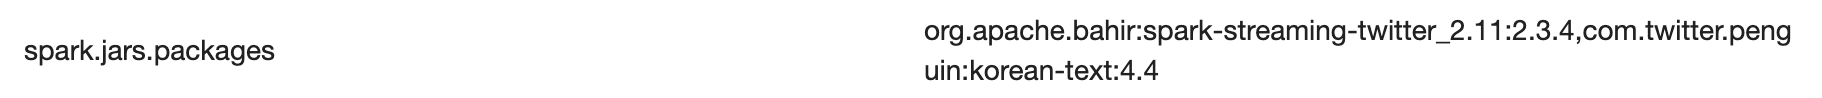

In [2]:
Image('./capture/word2vec_01.png')

-----
### Twitter 형태소 분석기

In [ ]:
import com.twitter.penguin.korean.TwitterKoreanProcessor
import com.twitter.penguin.korean.phrase_extractor.KoreanPhraseExtractor.KoreanPhrase
import com.twitter.penguin.korean.tokenizer.KoreanTokenizer.KoreanToken

val text = "한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ #한국어"
    println(">>>> 원문 : " + text)
    #한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ #한국어
    
    ##Normalize(정규화)
    val normalized: CharSequence = TwitterKoreanProcessor.normalize(text)
    println(">>>> Normalize(정규화) : " + normalized)
    #한국어를 처리하는 예시입니다ㅋㅋ #한국어

    ##Tokenize(토큰화)
    val tokens: Seq[KoreanToken] = TwitterKoreanProcessor.tokenize(normalized)
    println(">>>> Tokenize(토큰화) : " + tokens)
    #List(한국어(Noun: 0, 3), 를(Josa: 3, 1),  (Space: 4, 1), 처리(Noun: 5, 2), 하는(Verb: 7, 2),  (Space: 9, 1), 예시(Noun: 10, 2), 입니(Adjective: 12, 2), 다(Eomi: 14, 1), ㅋㅋ(KoreanParticle: 15, 2),  (Space: 17, 1), #한국어(Hashtag: 18, 4))

    ##Stemming(어근화)
    val stemmed: Seq[KoreanToken] = TwitterKoreanProcessor.stem(tokens)
    println(">>>> Stemming(어근화) : " + stemmed)
    #List(한국어(Noun: 0, 3), 를(Josa: 3, 1),  (Space: 4, 1), 처리(Noun: 5, 2), 하다(Verb: 7, 2),  (Space: 9, 1), 예시(Noun: 10, 2), 이다(Adjective: 12, 3), ㅋㅋ(KoreanParticle: 15, 2),  (Space: 17, 1), #한국어(Hashtag: 18, 4))

    ##Phrase extraction(어구 추출)
    val phrases: Seq[KoreanPhrase] = TwitterKoreanProcessor.extractPhrases(tokens, filterSpam = true, enableHashtags = true)
    println(">>>> Phrase extraction(어구 추출)(from Tokens) : " + phrases)
    #List(한국어(Noun: 0, 3), 처리(Noun: 5, 2), 처리하는 예시(Noun: 5, 7), 예시(Noun: 10, 2), #한국어(Hashtag: 18, 4))
    
    phrases.foreach { x => println(x.text) }
    
    
    ##Phrase extraction(어구 추출) #2
    val phrases2: Seq[KoreanPhrase] = TwitterKoreanProcessor.extractPhrases(stemmed, filterSpam = true, enableHashtags = true)
    println(">>>> Phrase extraction(어구 추출)(from Stemmed) #2 : " + phrases2)
    #List(한국어(Noun: 0, 3), 처리(Noun: 5, 2), 예시(Noun: 10, 2), #한국어(Hashtag: 18, 4))
    
    phrases2.foreach { x => println(x.text) }

- Normalize를 하지 않으면 '닼' 같은 단어를 처리할 수 없음.

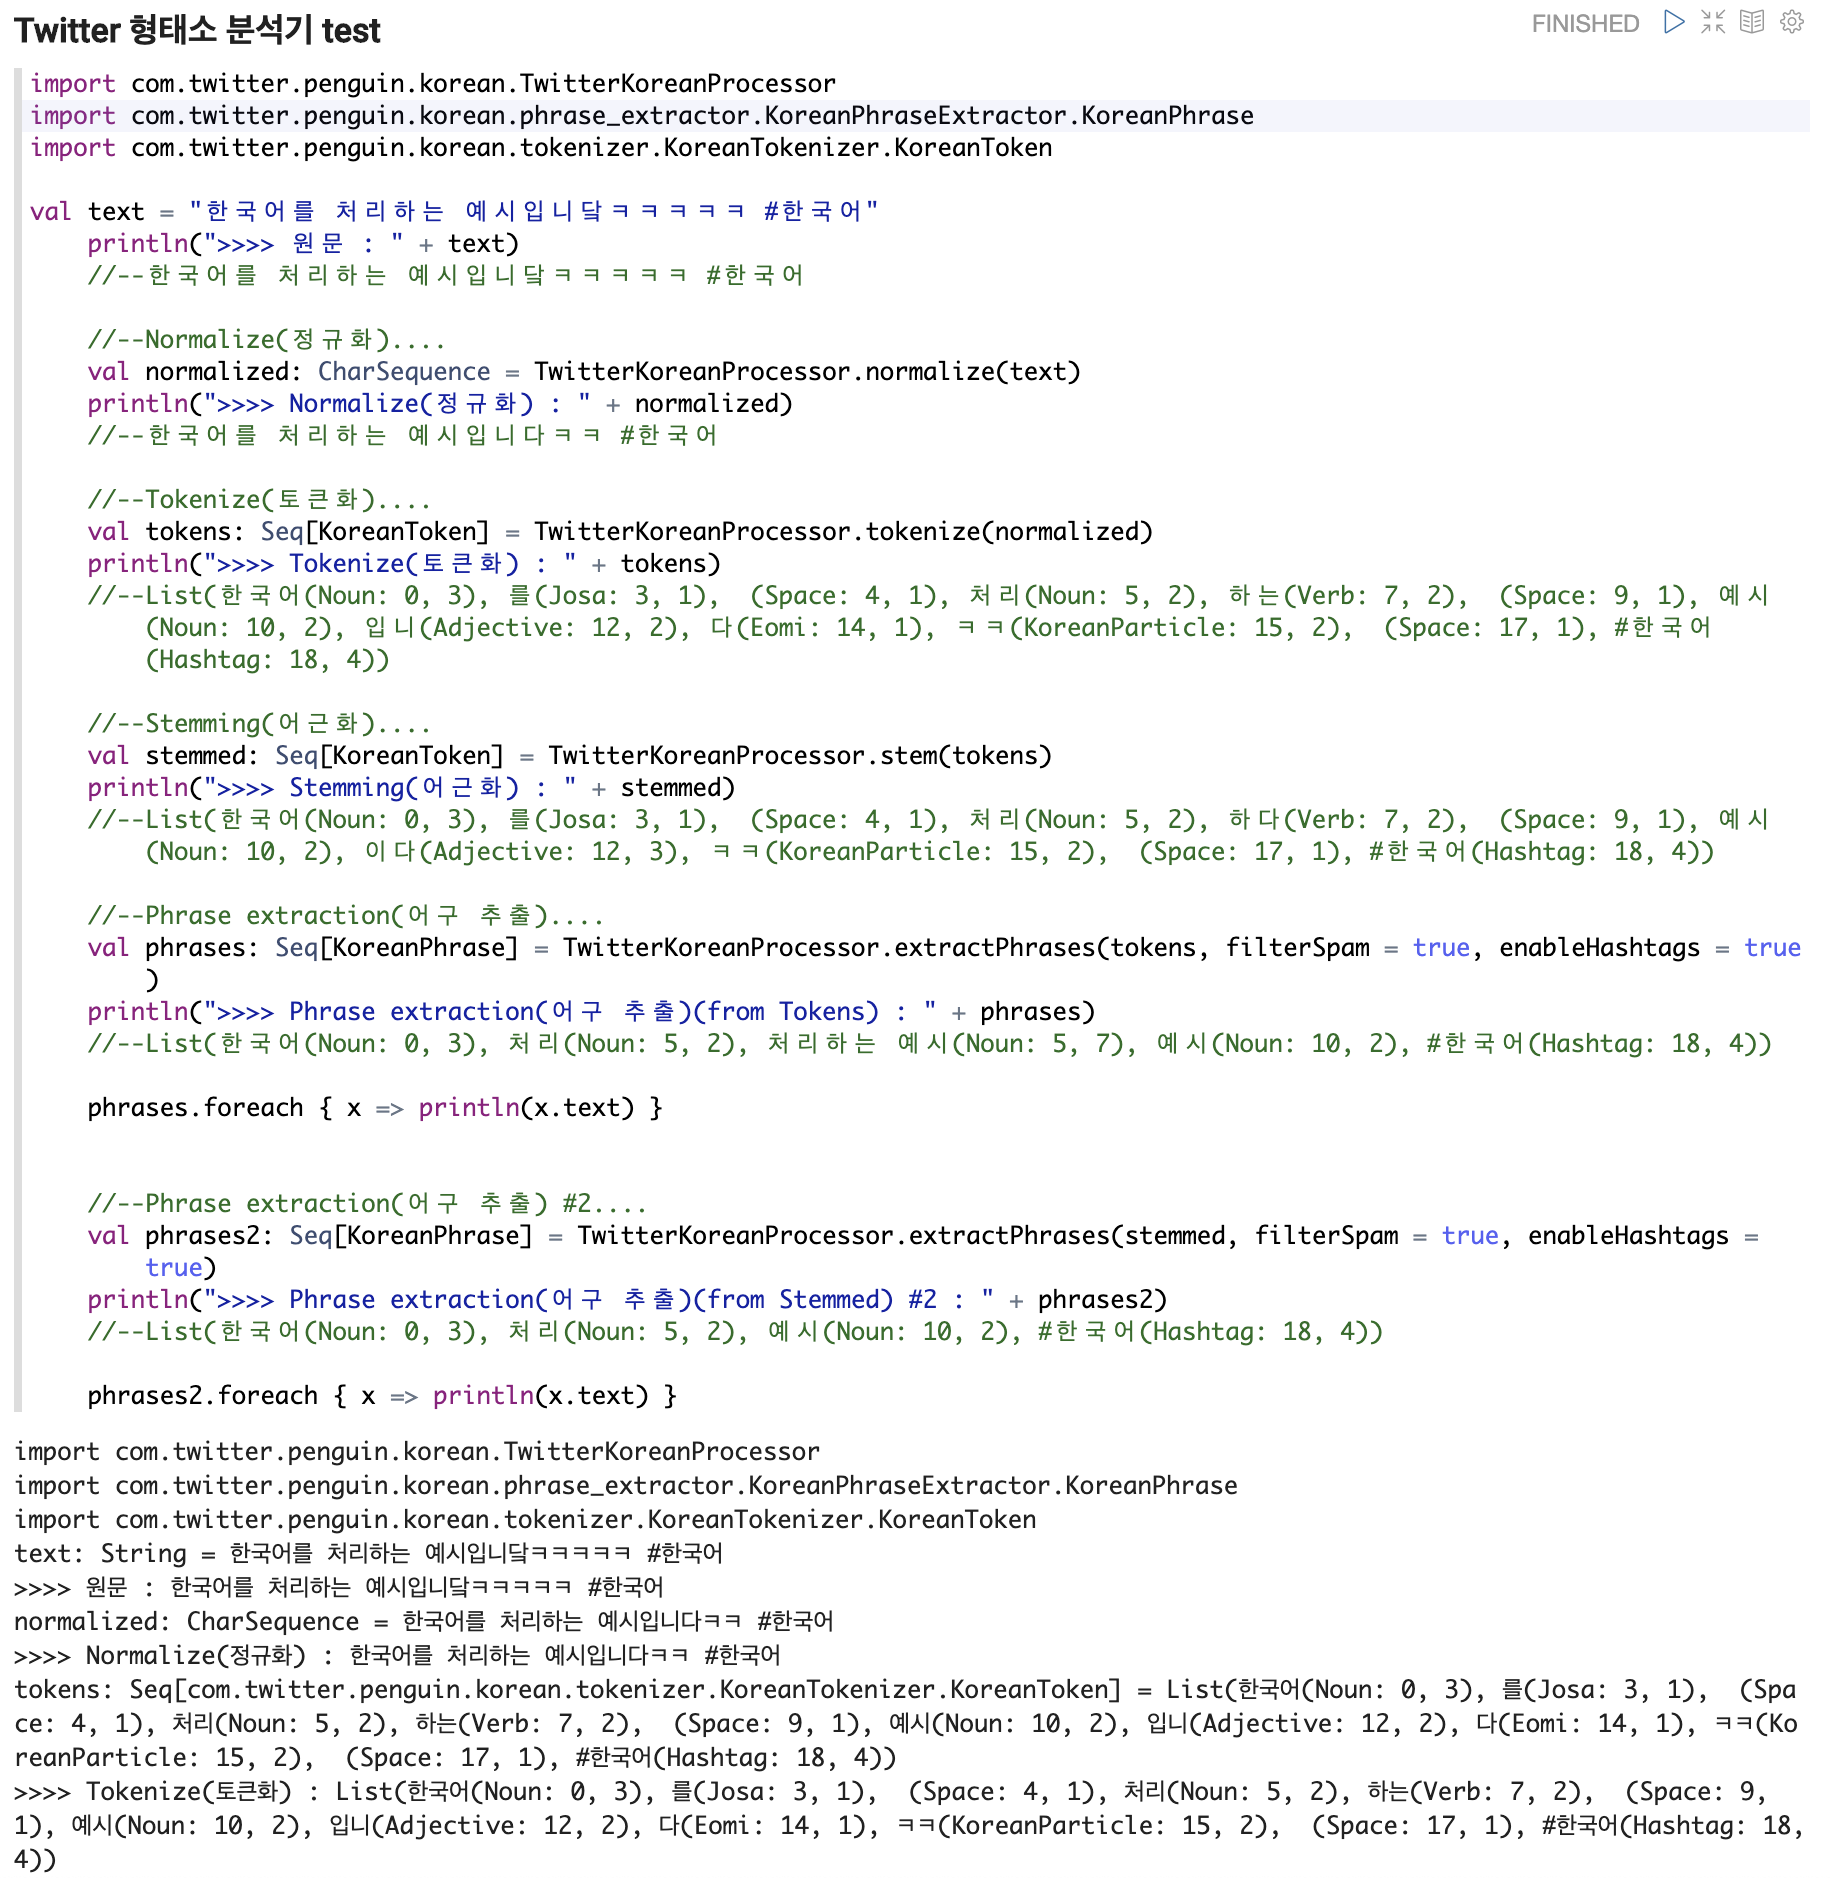

In [4]:
Image('./capture/penguin_02.png')


-----
### Word2Vec 학습데이터 정렬 - w/twitter 형태소 분석기

In [ ]:
# RDD[Seq[String]] => an RDD of sentences, each sentence is expressed as an iterable collection of words....

val input = sc
    .textFile("hdfs://hadoop-master-01:9000/kikang/data/news/news_*.txt")
    # Normalize(정규화)
    .map(text => TwitterKoreanProcessor.normalize(text))
    # Tokenize(토큰화)
    .map(normalized => TwitterKoreanProcessor.tokenize(normalized))
    # Stemming(어근화)
#     .map(tokens => TwitterKoreanProcessor.stem(tokens))
    # Phrase extraction(어구 추출)
    .map(stemmed => TwitterKoreanProcessor.extractPhrases(stemmed, filterSpam = true, enableHashtags = true))
    .map{phrases => phrases.map(_.text)}

input.take(5) 

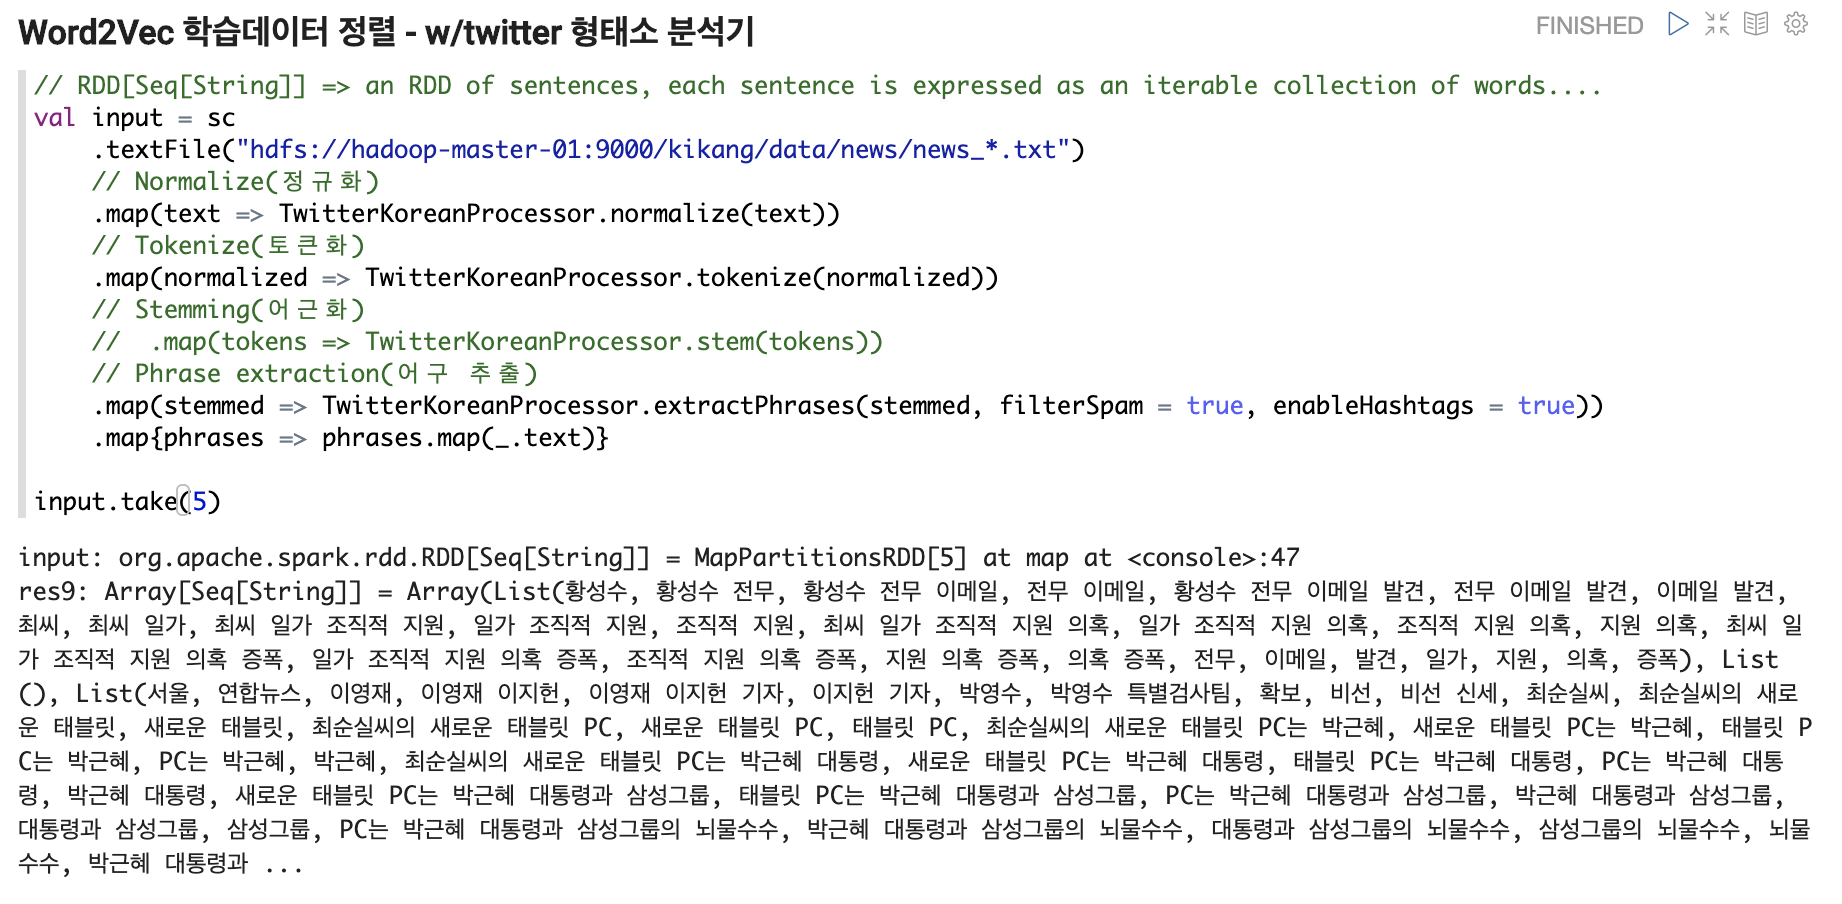

In [5]:
Image('./capture/word2vec_02.png')

----
### Word2Vec Training


- Word2Vec creates "vector representation of words" in a text corpus
- The algorithm first constructs a "vocabulary" from the corpus 
- and then learns "vector representation" of words in the vocabulary 
- The "vector representation" can be used as "features" in "natural language processing" and "machine learning" algorithms
- We used "Skip-gram model" (cf.CBOW:Continuous Bag-of-Words) in our implementation and "hierarchical softmax" method to train the model

- The variable names in the implementation matches the original C implementation
- For original C implementation, see https://code.google.com/p/word2vec/ 

- For research papers, see "Efficient Estimation of Word Representations in Vector Space" and "Distributed Representations of Words and Phrases and their Compositionality"
- A. Efficient Estimation of Word Representations in Vector Space
: https://arxiv.org/pdf/1301.3781.pdf
- B. Distributed Representations of Words and Phrases and their Compositionality
: https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
: https://pdfs.semanticscholar.org/f105/1ed2b078bef7fc36640c0dc480cb0b4511f6.pdf

---
- 기본적으로 언어학의 "Distributional Hypothesis" 라는 가정에 입각하여 이루어짐
    -  "비슷한 분포를 가진 단어들은 비슷한 의미를 가진다" 라는 의미
    -  "비슷한 분포를 가졌다"는 것은 기본적으로 단어들이 같은 문맥에서 등장한다는 것을 의미
    -  "가까이 위치해있는 단어일 수록 현재 단어와 관련이 더 많은 단어일 것이다" 라는 의미

In [ ]:
import org.apache.spark.mllib.feature.{Word2Vec, Word2VecModel}

val word2vec = new Word2Vec()

//--Word2VecModel....
val model = word2vec
#   Sets initial learning rate (default: 0.025)
    .setLearningRate(0.025)      
#   Sets the maximum length (in words) of each sentence in the input data. Any sentence longer than this threshold will be divided into chunks of up to maxSentenceLength size (default: 1000)
    .setMaxSentenceLength(1000)  
#   Sets minCount, the minimum number of times a token must appear to be included in the word2vec model's vocabulary (default: 5)
    .setMinCount(5)              
#   Sets random seed (default: a random long integer)
    .setSeed(1L)                 
#   Sets vector size (default: 100)
    .setVectorSize(100)    
#   Sets the window of words (default: 5)
    .setWindowSize(5)  
#   Computes the vector representation of each word in vocabulary
    .fit(input)                  

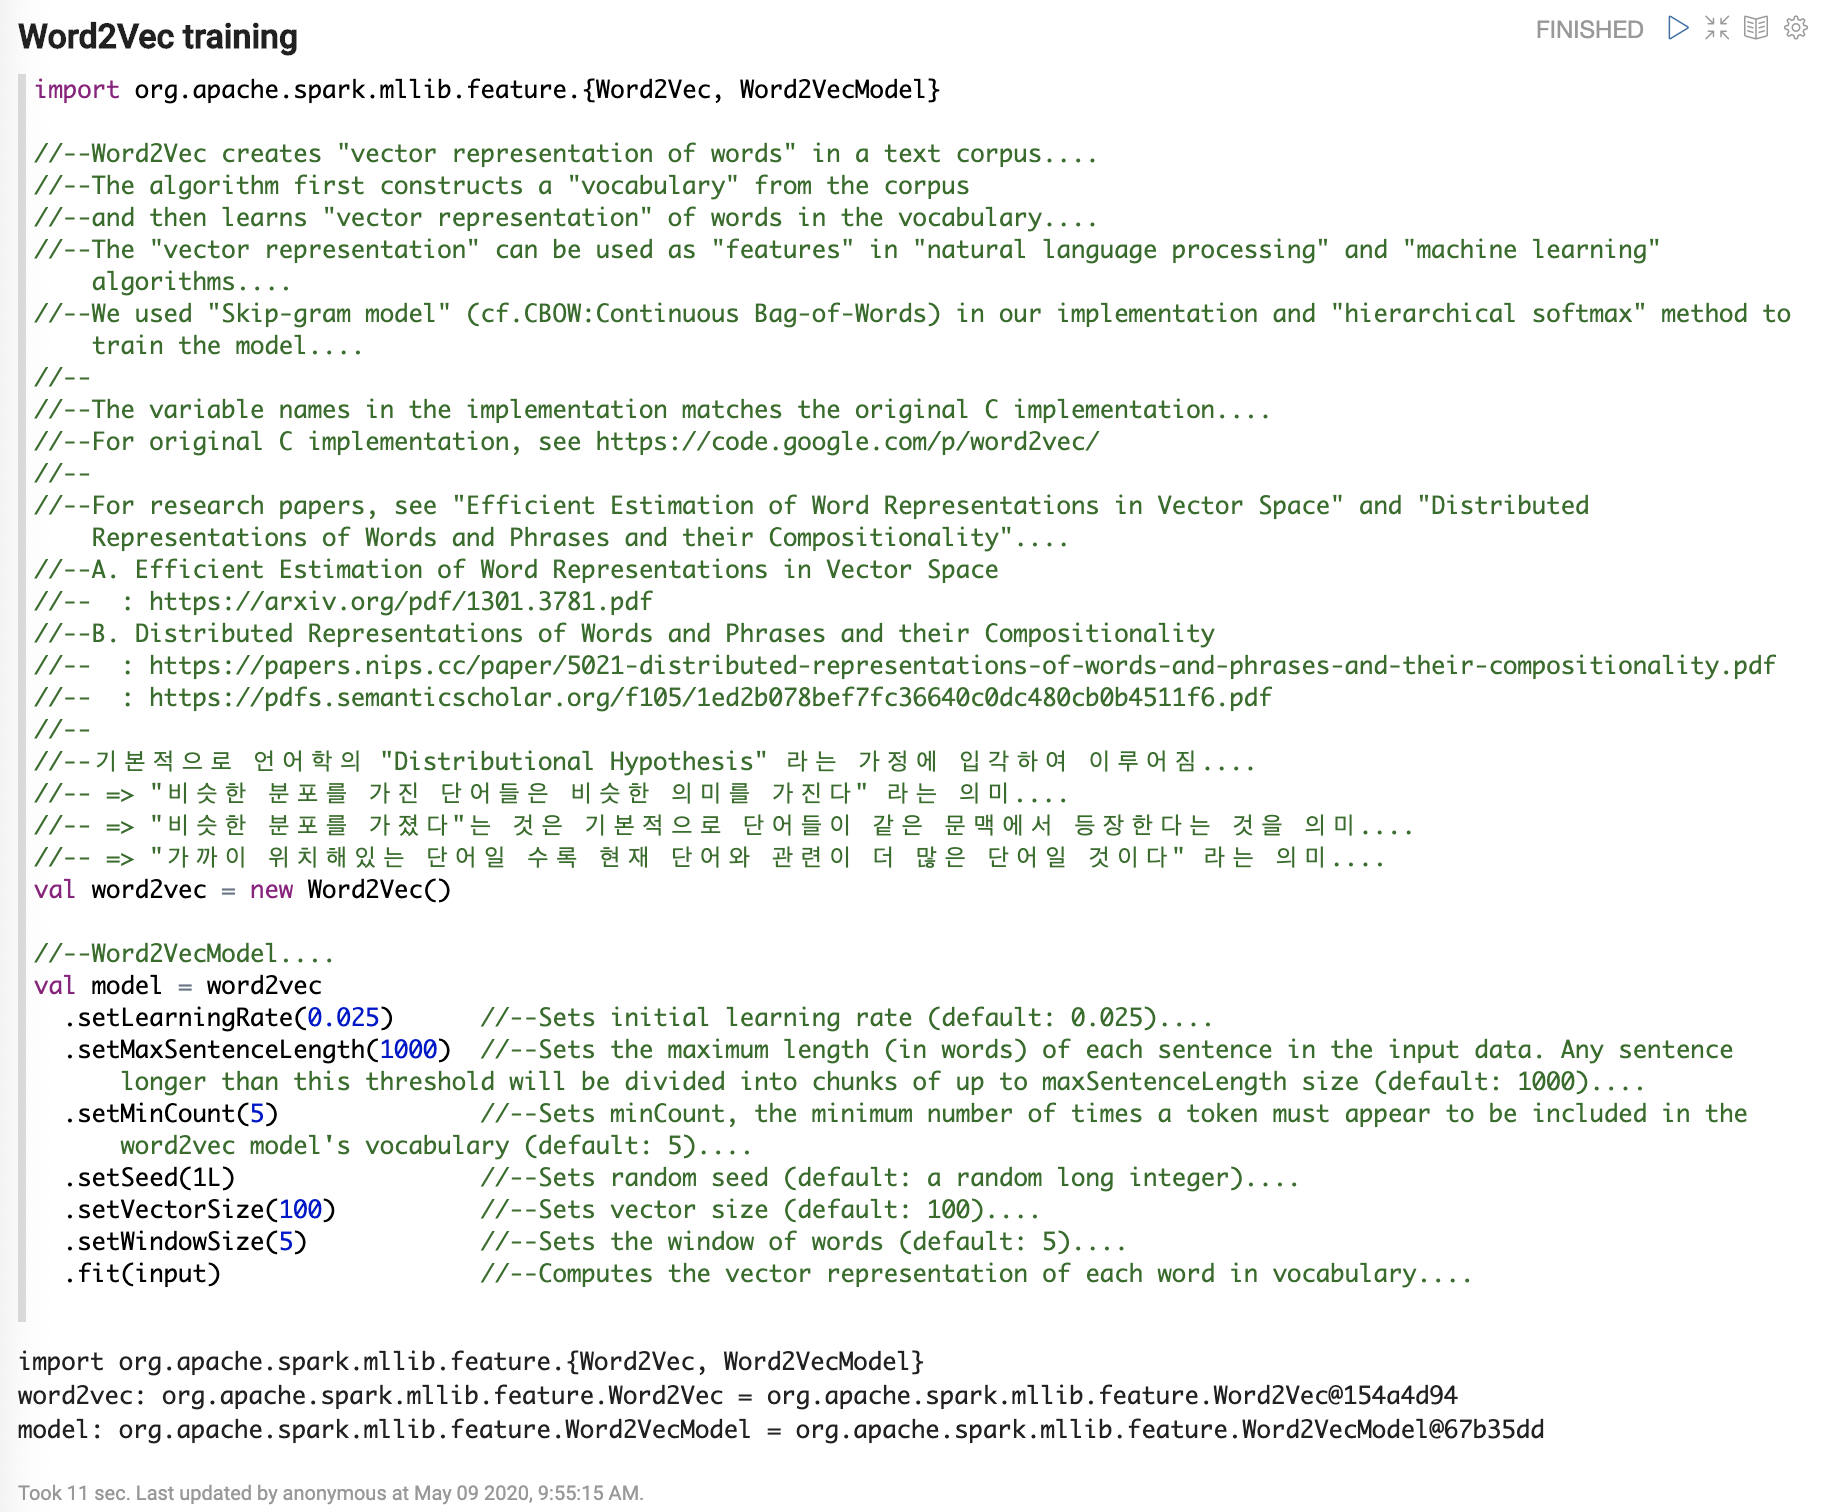

In [6]:
Image('./capture/word2vec_03.png')

----
### 유사어 찾아보기

In [ ]:
# findSynonyms....
# Find synonyms of a word; do not include the word itself in results

val synonyms = model.findSynonyms("최씨", 5)
val synonyms = model.findSynonyms("이재용", 5)

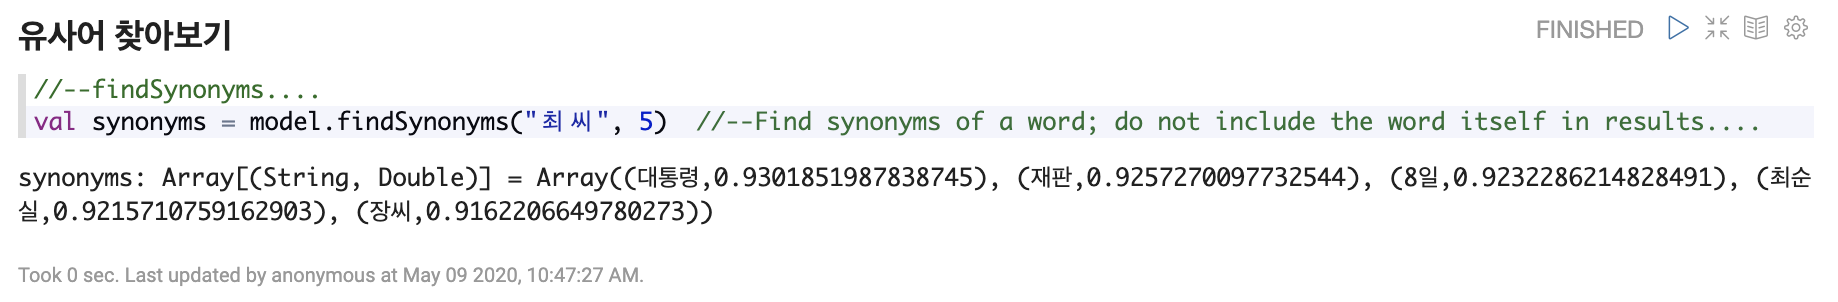

In [8]:
Image('./capture/word2vec_04.png')

### 유사어 찾아보기 ('최씨' w/유사도(cosineSimilarity)

In [ ]:
println(s""">>>> Synonyms of a word '최씨'.... """)

for((synonym, cosineSimilarity) <- synonyms) {
  println(s"$synonym $cosineSimilarity")
}
println("\n")

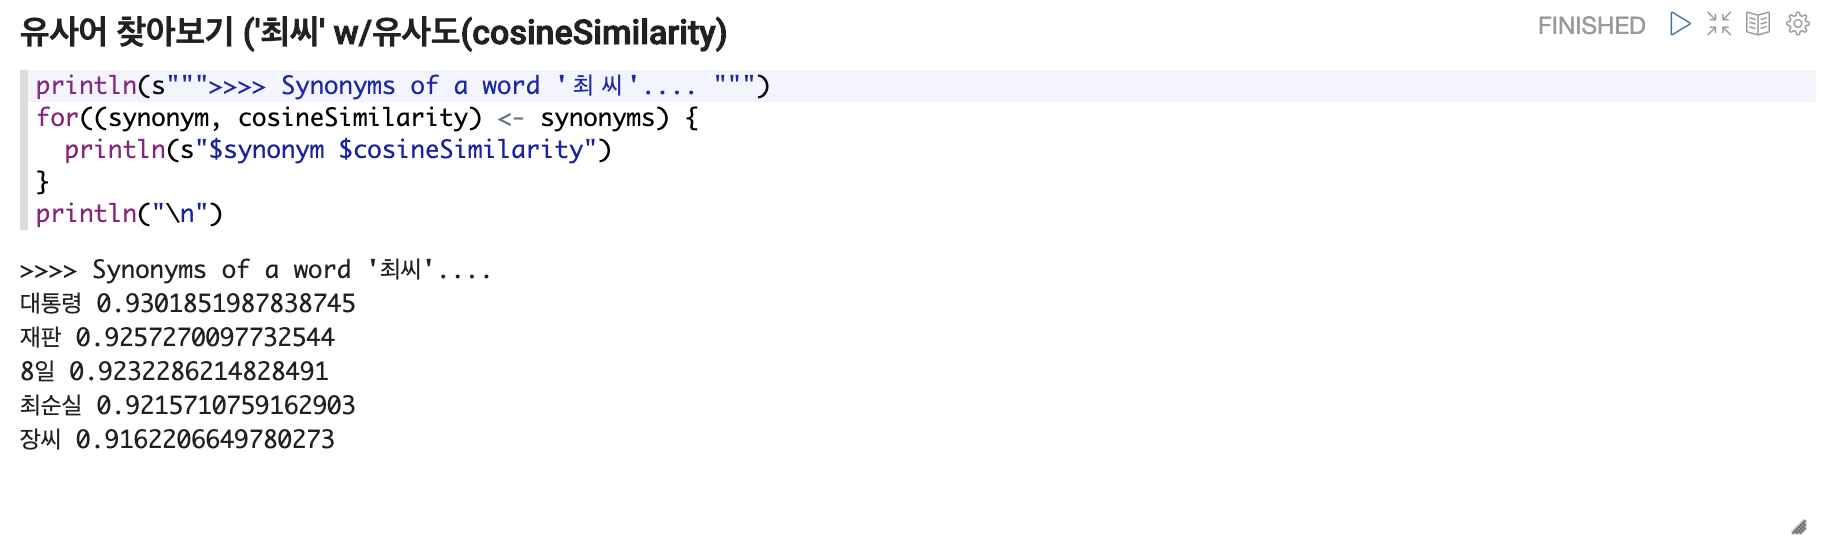

In [9]:
Image('./capture/word2vec_05.png')

### Save model

In [ ]:
model.save(sc, "hdfs://hadoop-master-01:9000/kikang/data/news_word2vec")

### Load model

In [ ]:
val sameModel = Word2VecModel.load(sc, "hdfs://hadoop-master-01:9000/kikang/data/news_word2vec")

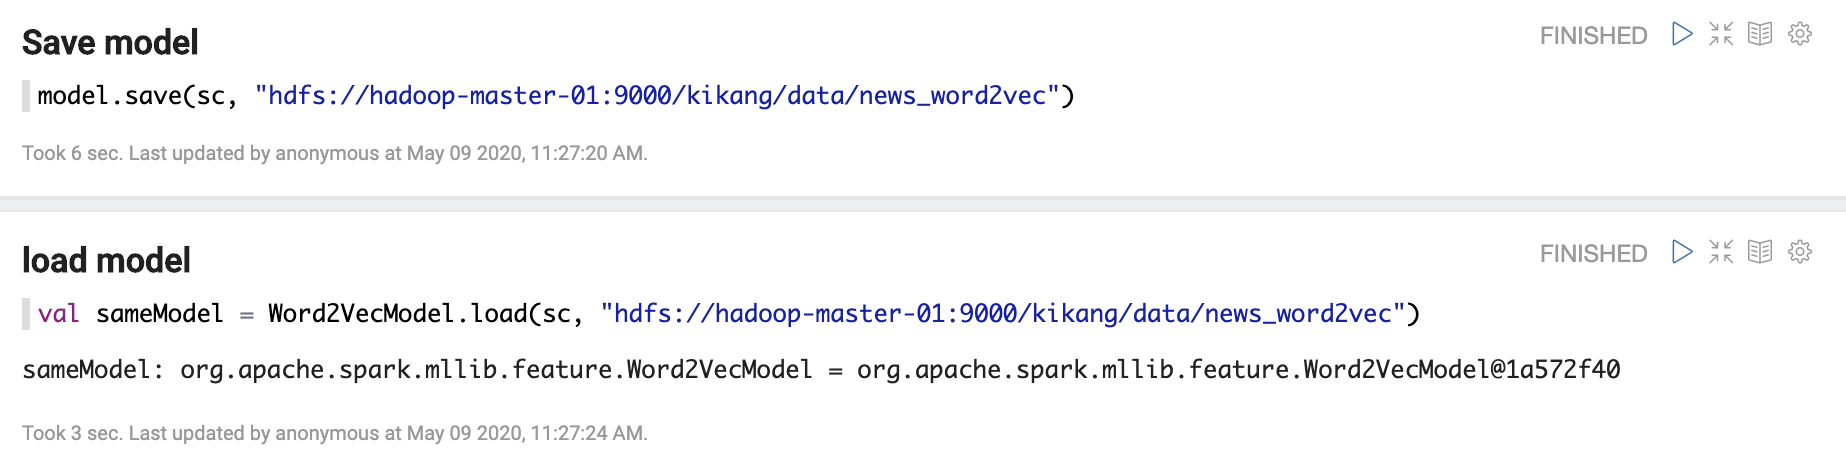

In [17]:
Image('./capture/word2vec_06.png')

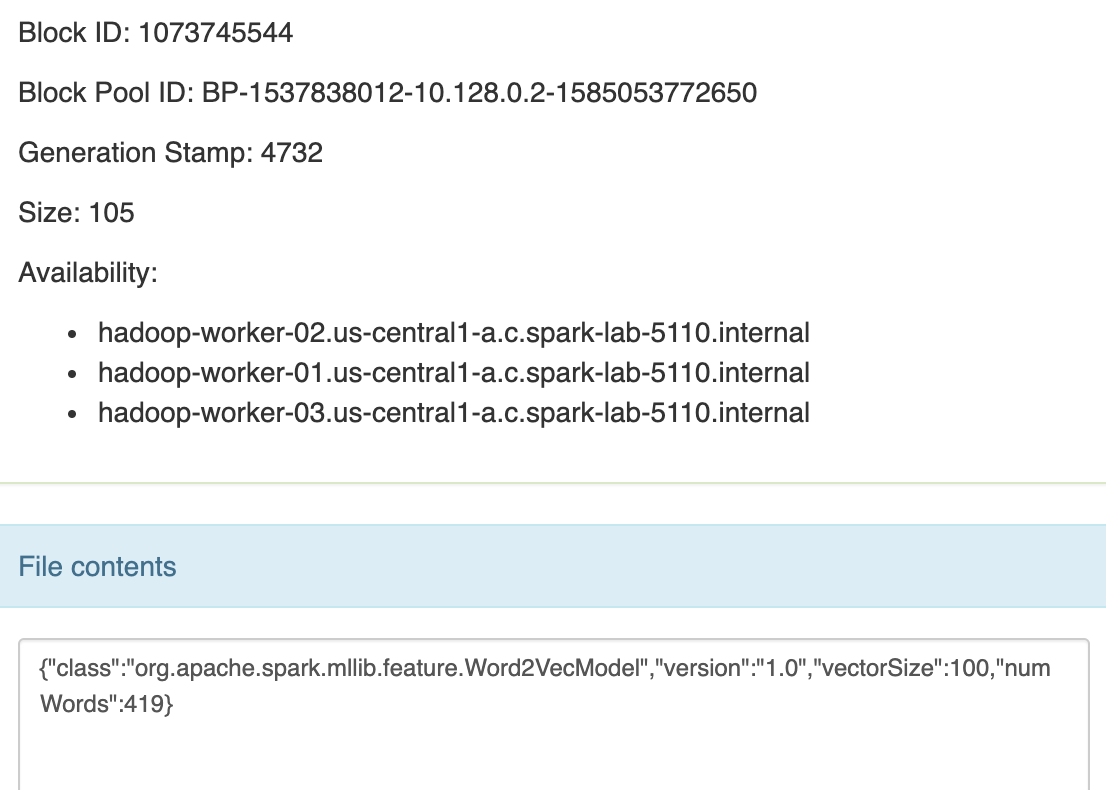

In [11]:
Image('./capture/word2vec_07.png')

----
### findSynonyms for ALL words

In [ ]:
println(s""">>>> Synonyms of ALL words in vocabulary.... """)
# def getVectors: Map[String, Array[Float]] => Returns a map of words to their vector representations

sameModel.getVectors.foreach{wordAndVector =>     
  sameModel.findSynonyms(wordAndVector._1, 5).foreach{case (synonym, cosineSimilarity) => 
    println(s"${wordAndVector._1} => ${synonym} ${cosineSimilarity}")
  }
}

println(s"""\n>>>> Count of ALL words in vocabulary : ${sameModel.getVectors.size}.... """) 

println("\n")

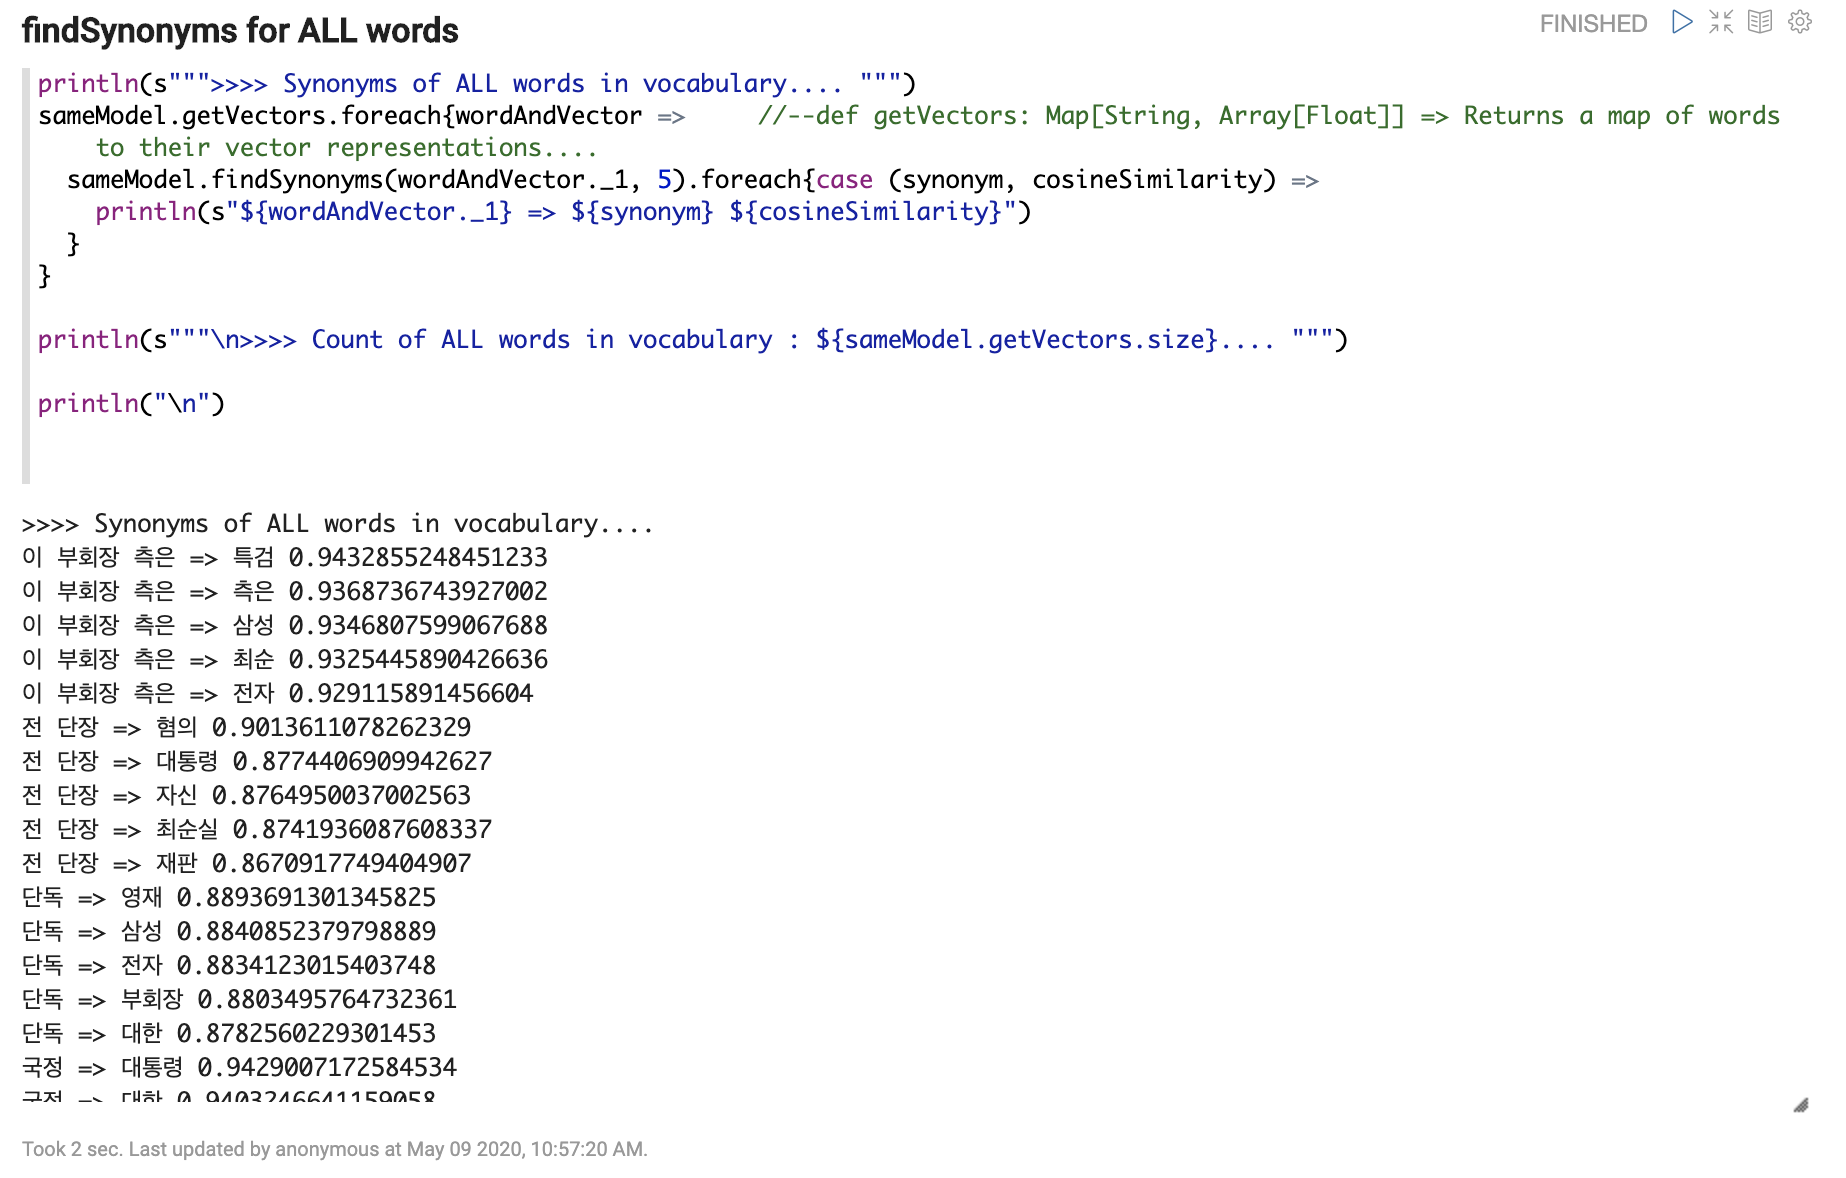

In [12]:
Image('./capture/word2vec_08.png')

----

### 관계에 의한 단어 탐색

* 더 많은 한국어 코퍼스를 사용한 단어 임베딩 모형은 다음 웹사이트에서 테스트해 볼 수 있음....
* 나무위키와 한국어 위키백과를 이용해서 학습....
* http://w.elnn.kr/ => ex) 한국-서울+도쿄 ≈ 일본, 남자-왕+여왕 ≈ 여자, 박찬호-야구+축구, 애교-고양이+강아지

-----
### 특정 단어에 대한 Vector (or metrix) 연산을 위한 DenseVector(or DenseMatrix) 생성하기

#### google search 
 - org.jblas.DoubleMatrix maven

#### web site
 - https://mvnrepository.com/artifact/org.jblas/jblas/1.2.4
  - version check
 - Maven Tab copy
 
----

- spark3 interpreter :: spark.jars.packages add

    org.jblas:jblas:jar:1.2.4

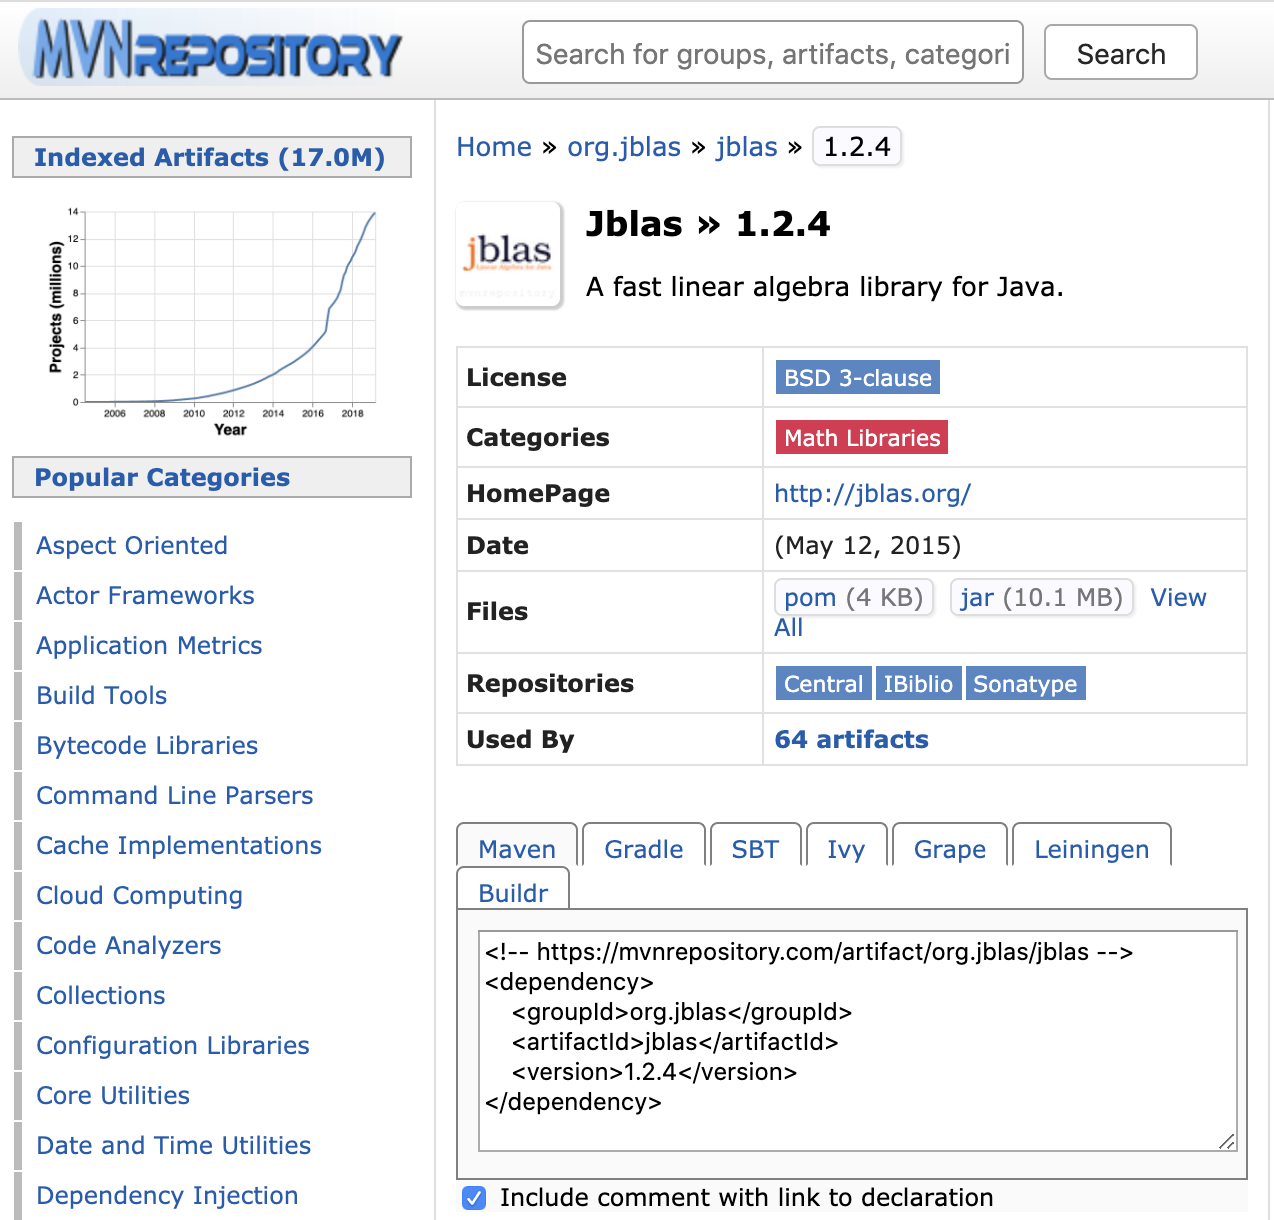

In [16]:
Image('./capture/word2vec_09.png')

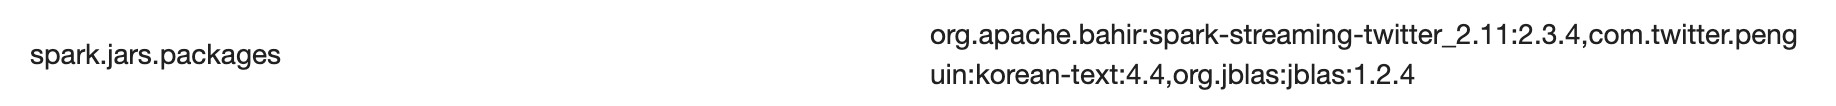

In [15]:
Image('./capture/word2vec_10.png')

In [ ]:
import org.jblas.{DoubleMatrix => DM}
import breeze.linalg.{DenseVector => DV}

# by breeze
def word2DV(word: String) = {
# new DenseVector(model.getVectors.get(word).get.map(_.toDouble))
  new DV(model.getVectors.get(word).get.map(_.toDouble))
}

# by jblas
def word2DM(word: String) = {
# new DoubleMatrix(model.getVectors.get(word).get.map(_.toDouble))
  new DM(model.getVectors.get(word).get.map(_.toDouble))
}

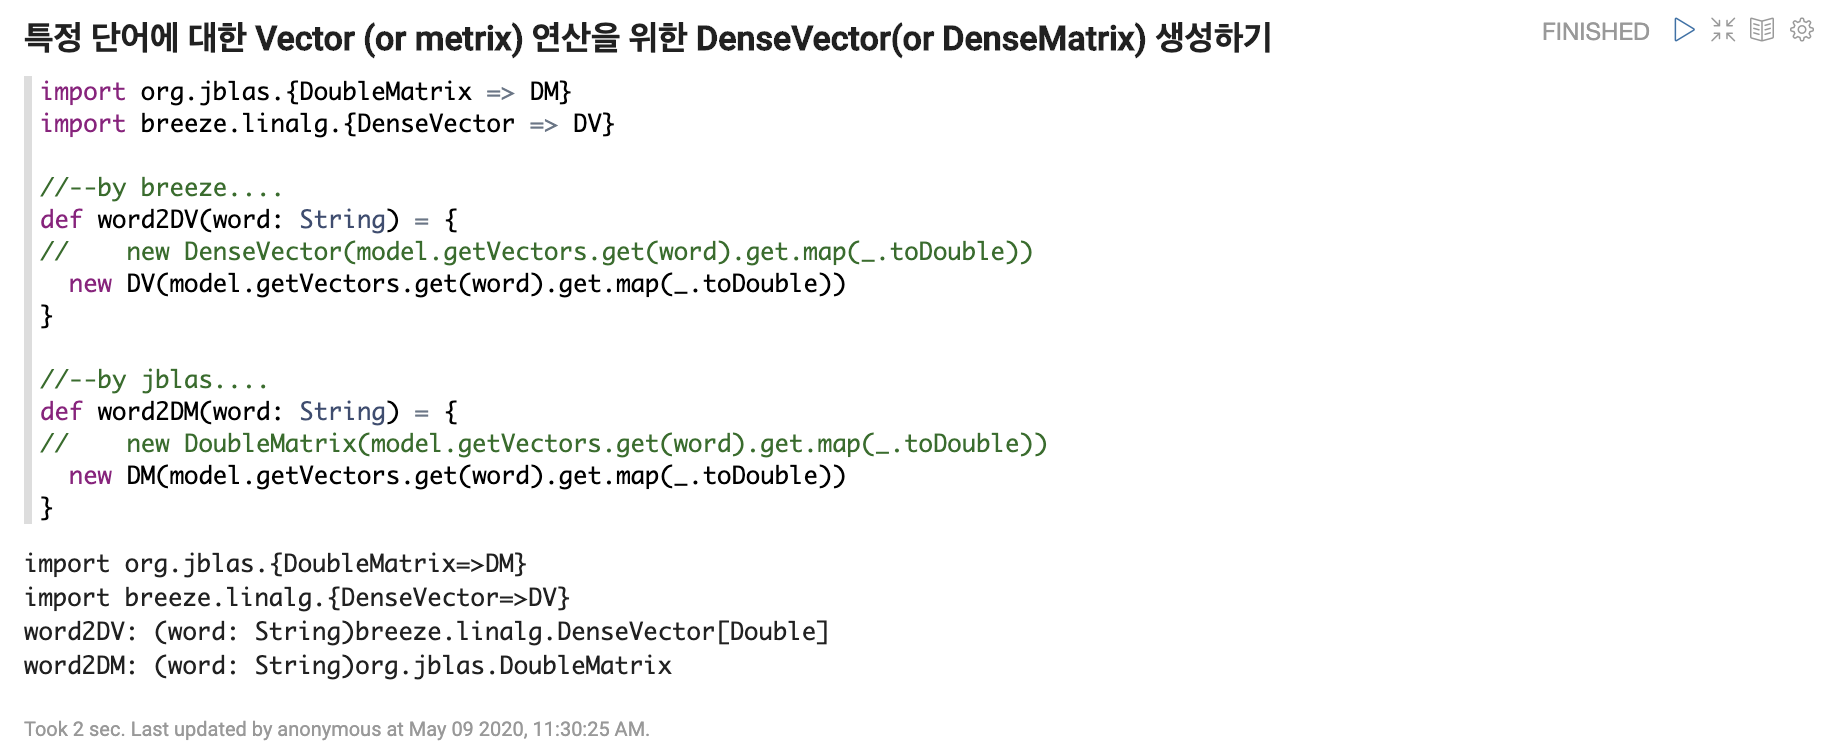

In [18]:
Image('./capture/word2vec_11.png')

----
### 특정 단어들(3개단어)에 대한 연산 수행을 위한 함수 정의

In [ ]:
import org.apache.spark.mllib.linalg.Vectors
import org.apache.spark.mllib.linalg.Vector

#searchByRelation....with DoubleMatrix
#Math operations on word vectors
#vec("Germany") + vec("capital") ≈ vec("Berlin")
#vec("Steve Ballmer") - vec("Microsoft") + vec("Google") ≈ vec("Larry Page")

def searchByRelation(positiveWord: String, negativeWord: String, positiveWord2: String, num: Int) {
  val target = word2DM(positiveWord).sub(word2DM(negativeWord)).add(word2DM(positiveWord2))
#findSynonyms(vector: Vector, num: Int): Array[(String, Double)]....Find synonyms of the vector representation of a word, possibly including any words in the model vocabulary whose vector representation is the supplied vector.
  val result = sameModel.findSynonyms(Vectors.dense(target.toArray), num)
  result.foreach{case (synonym, cosineSimilarity) =>
    println(s"${synonym} ${cosineSimilarity}")
  }
  println("\n")
}

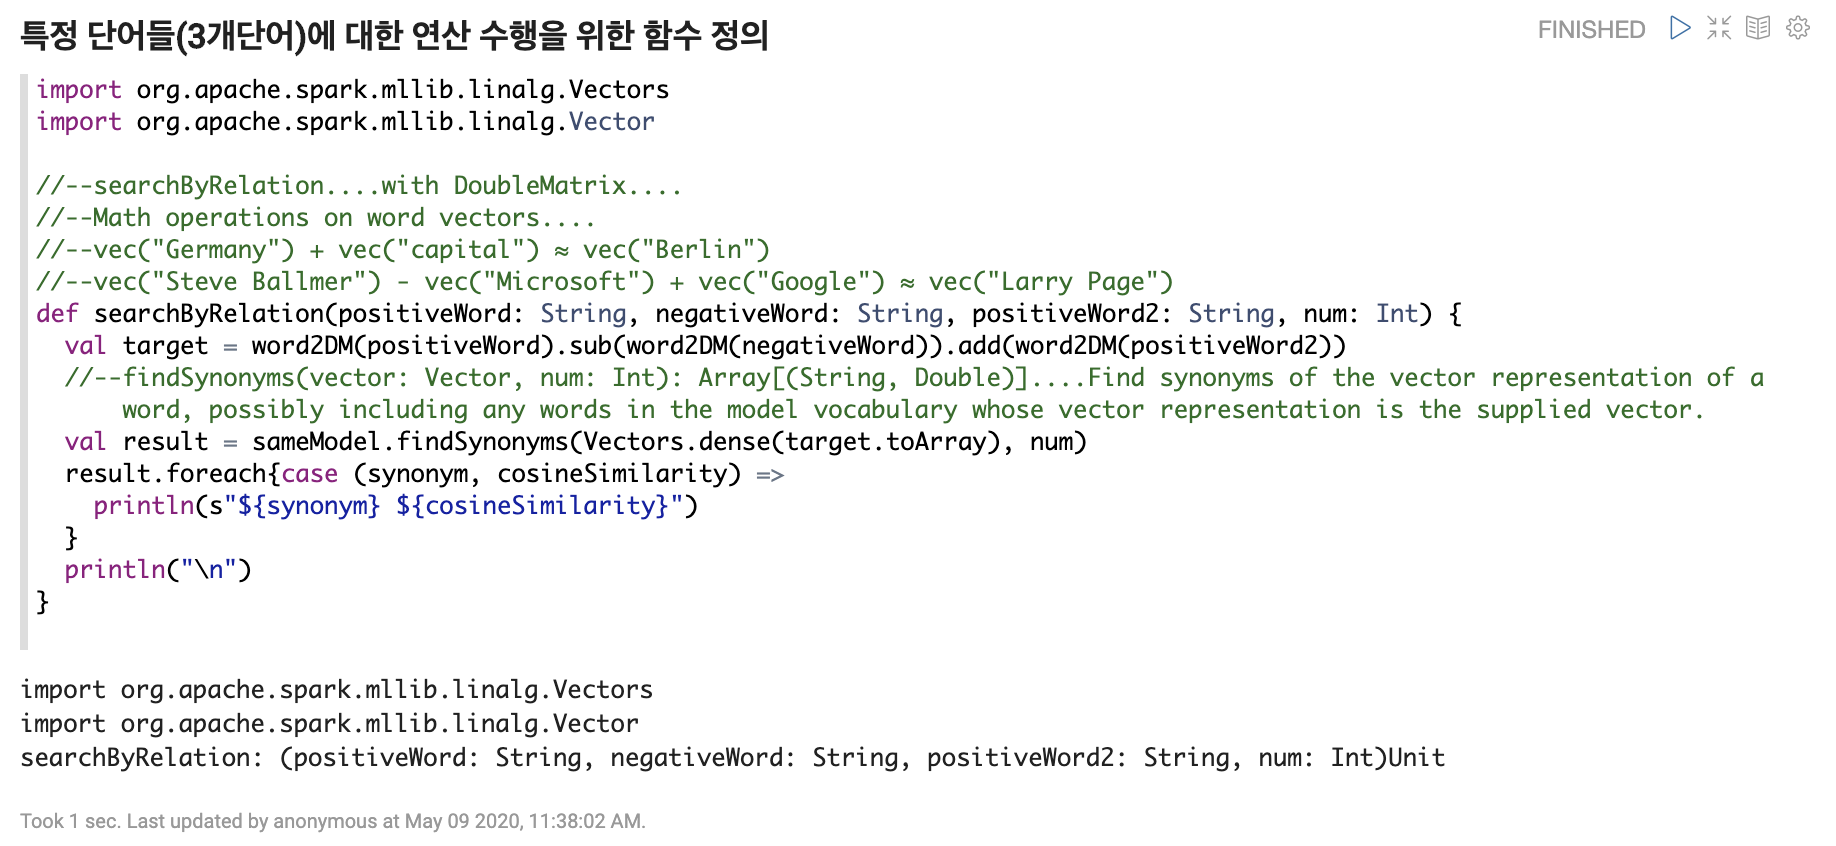

In [21]:
Image('./capture/word2vec_12.png')

---
### 연산수행

In [ ]:
println(">>>> [Relation #01] ???? = 이재용 - 삼성 + K스포츠재단")
searchByRelation("이재용", "삼성", "K스포츠재단", 5)

println(">>>> [Relation #02] ???? = 최순실 - K스포츠재단 + 미르")
searchByRelation("최순실", "K스포츠재단", "미르", 5)

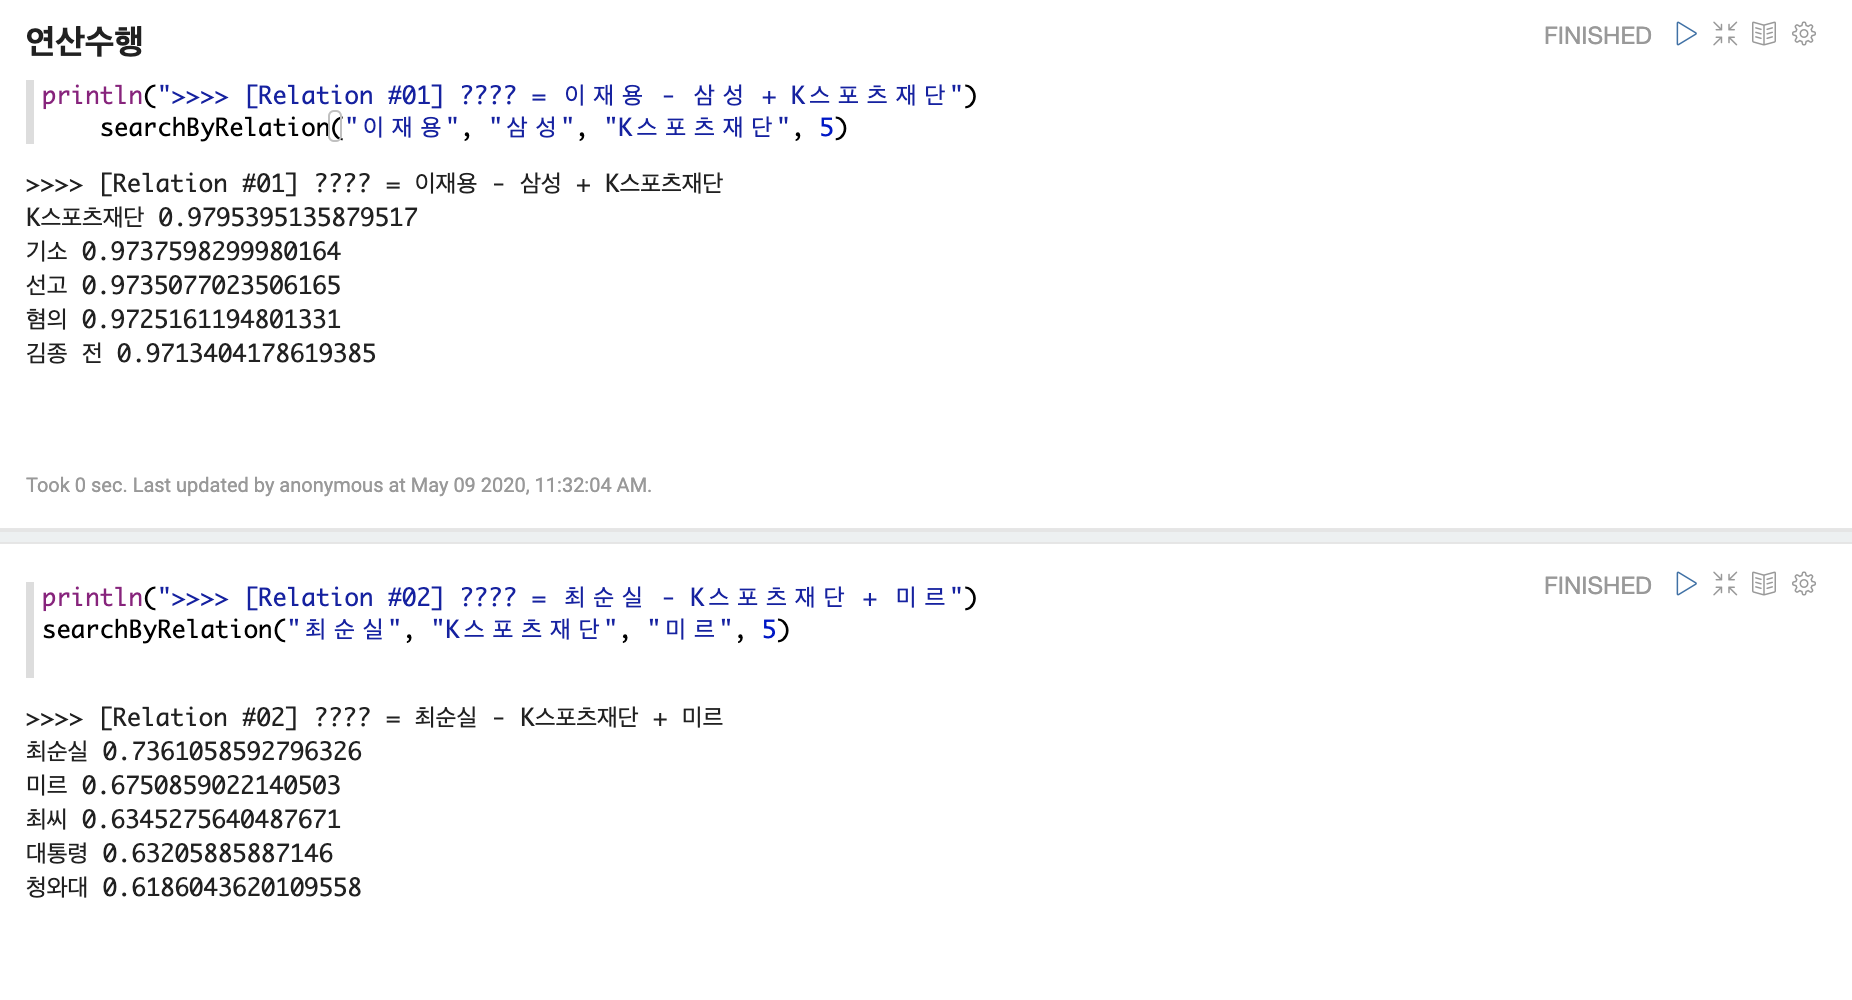

In [19]:
Image('./capture/word2vec_13.png')

---------
### zepplin chart

 - Choosing the Number of Clusters(Elbow Method)
 
     -> 트위터 랭귀지 분류 (by Kmeans) 파일 참조
     
------
#### Within Set Sum of Squared Error (WSSSE)....

In [ ]:
import org.apache.spark.mllib.clustering.KMeans
import org.apache.spark.rdd.RDD
import org.apache.spark.mllib.linalg.Vector

# 트윗 수집 디렉토리 경로, 모델 저장 디렉토리 경로(머신러닝), 클러스터 개수(머신러닝), 반복 회수(머신러닝) 설정
val Array(tweetInput, outputModelDir, numClusters, numIterations) 
  = Array("hdfs://hadoop-master-01:9000/kikang/data/twitter" + "/tweets_*/part-*", "hdfs://hadoop-master-01:9000/kikang/data/twitter_kmeans" + "/model", "100", "50")

# Spark SQL로 JSON 파일 읽은 후 캐시.... => 결과는 Dataset
val tweetTable = spark.read.json(tweetInput).cache()
# 캐시된 Dataset으로 Temp View 생성
tweetTable.createOrReplaceTempView("tweetTable")

val texts = spark.sql("SELECT text from tweetTable").map(_.toString)    
val vectors = texts.map(Utils.featurize)(org.apache.spark.sql.Encoders.kryo[Vector]).rdd.cache()  //--Cache the vectors RDD since it will be used for all the KMeans iterations.

# WSSSE Visualization
var wssseSeq: Seq[(Int, Double)] = Seq()

def clustering(data: RDD[Vector], k: Int) = {
  val kmeans = new KMeans()
  kmeans.setK(k)
  kmeans.setMaxIterations(numIterations.toInt)
  kmeans.setInitializationMode("k-means||")
  kmeans.setSeed(11L)
  val model = kmeans.run(data)
# sum of squared distances of points to their nearest center => compute 'Within Set Sum of Squared Error'(WSSSE)
  val wssse = model.computeCost(data)  
  wssseSeq = wssseSeq :+ (k, wssse)
  println(s""">>>> k: ${k}, WSSSE: ${wssse}""")      
}

(10 to 150 by 10).map(k => (k, clustering(vectors, k)))

wssseSeq

#### WSSSE Visualization....

In [ ]:
println(s"""%table
k\twssse
${wssseSeq.map(x => x._1 + "\t" + x._2).mkString("\n")}
""")

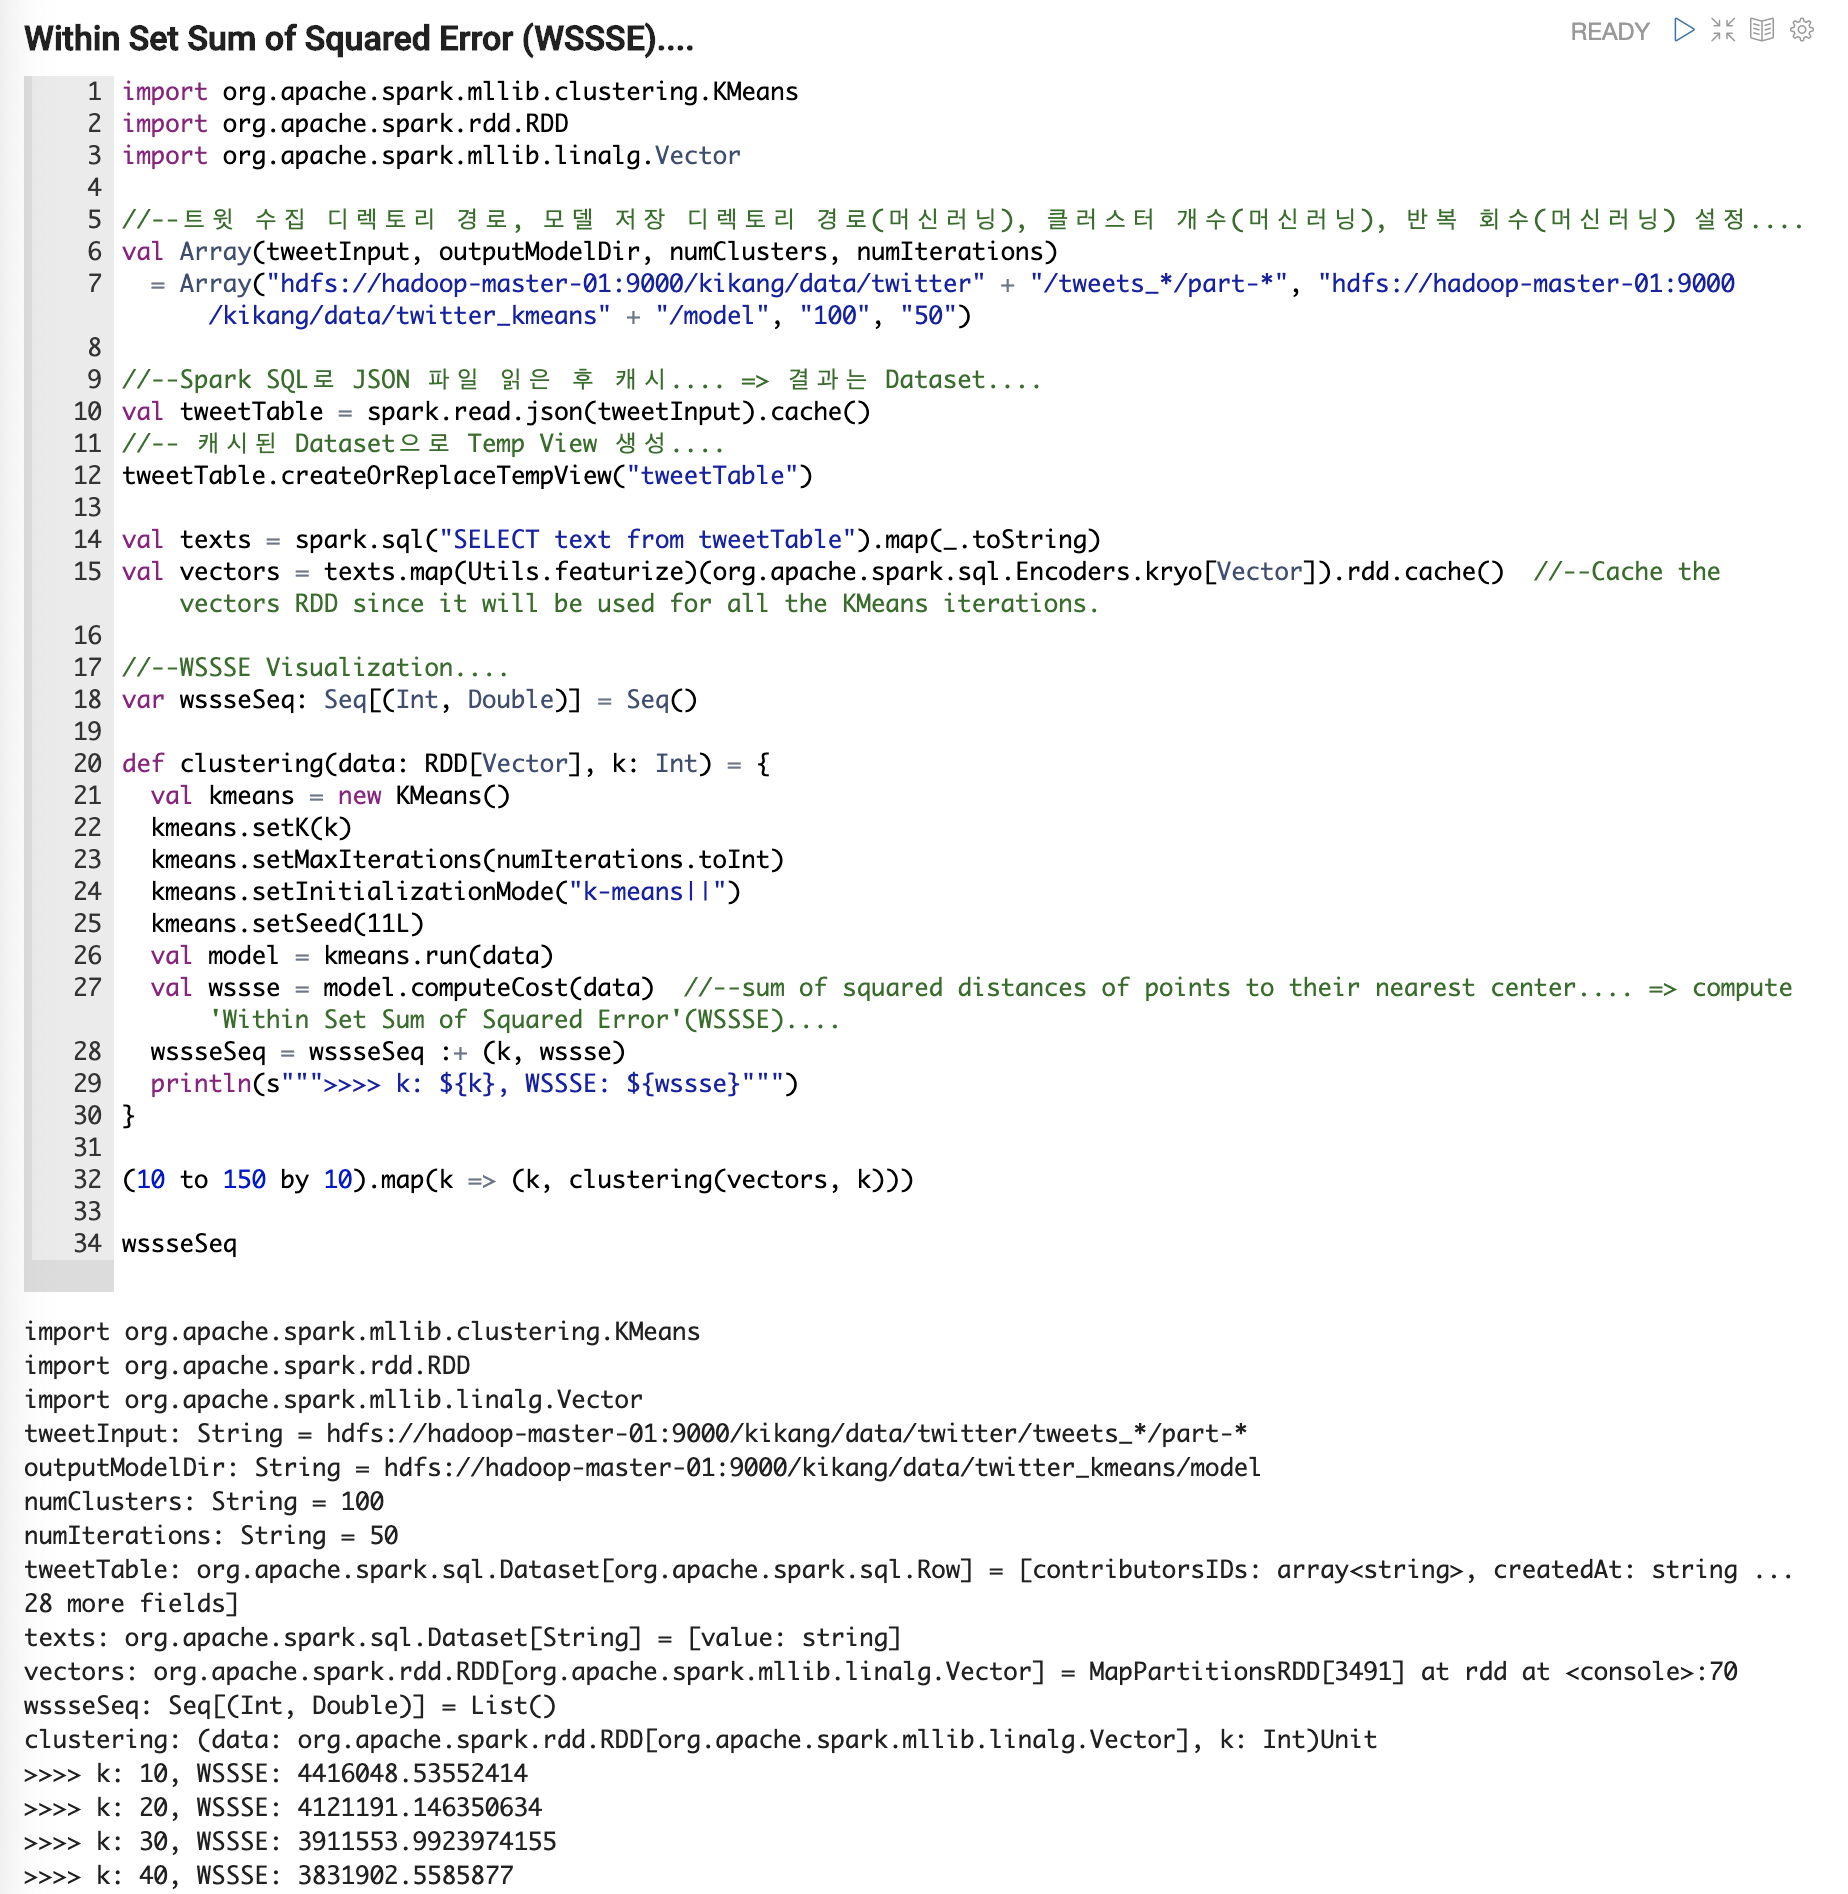

In [22]:
Image('./capture/word2vec_14_01.png')

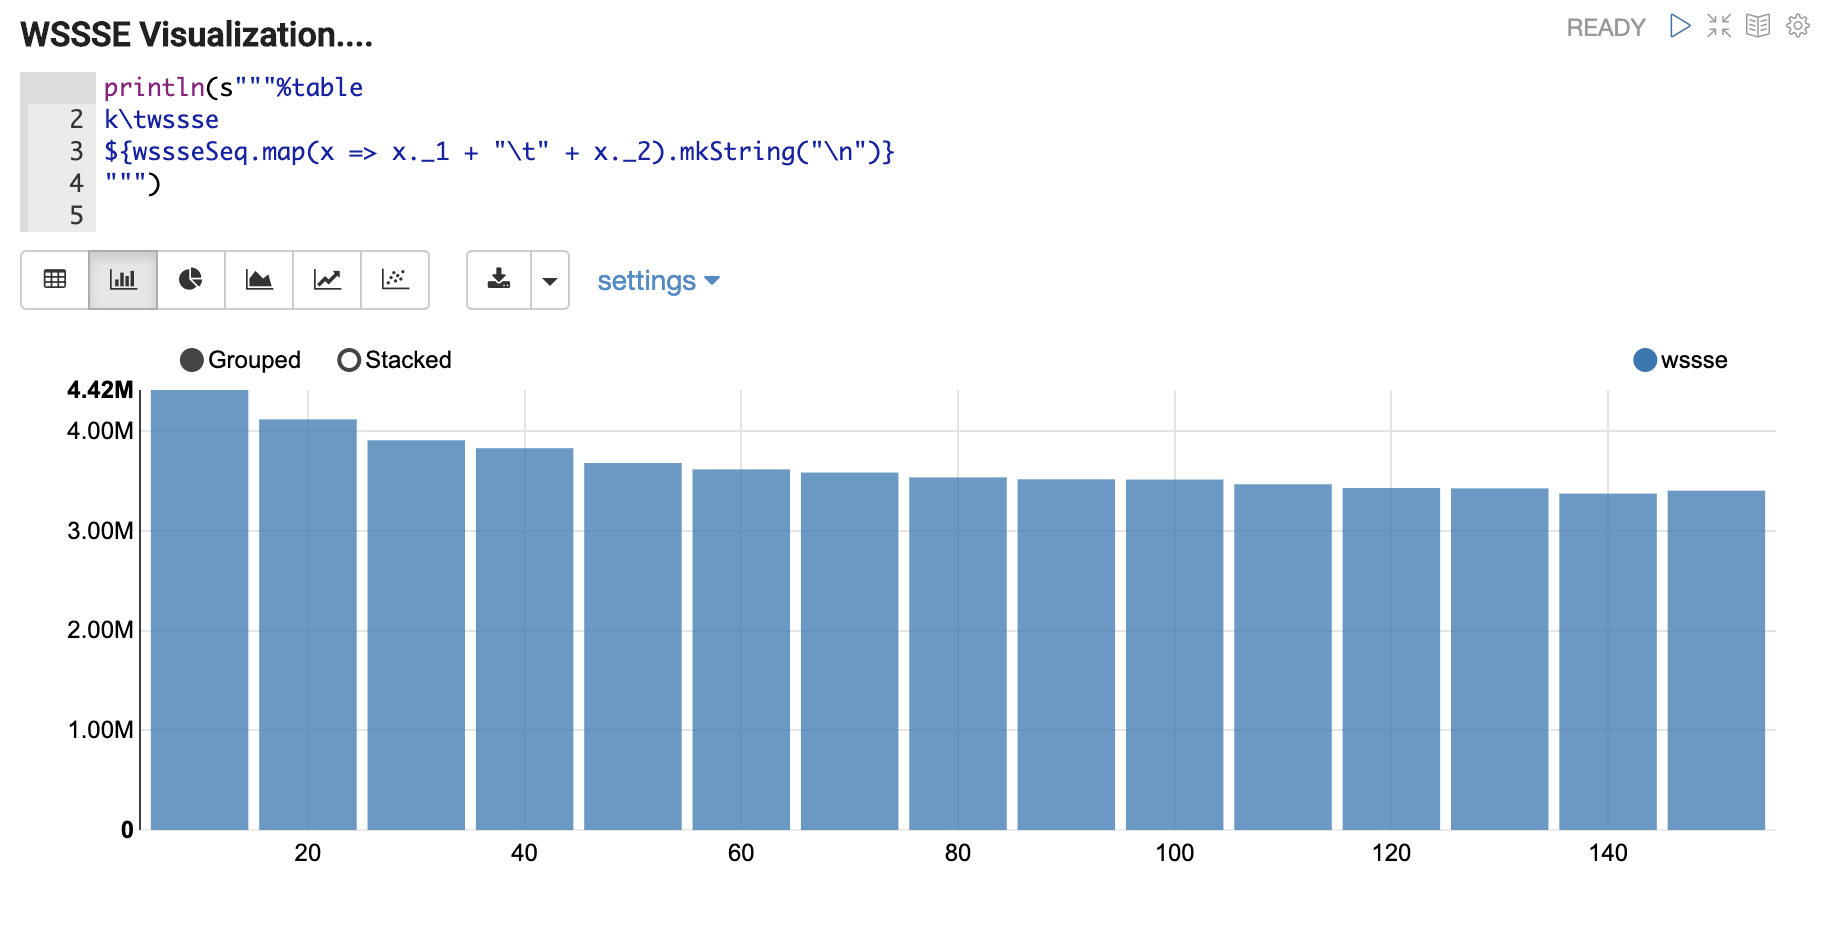

In [23]:
Image('./capture/word2vec_14_02.png')

------

#### scala table

 - 첫 줄은 column
 - 두번째 줄부터는 value

In [ ]:
println(s"""%table
col1\tcol2\tcol3 
col1\tcol2\tcol3
""")

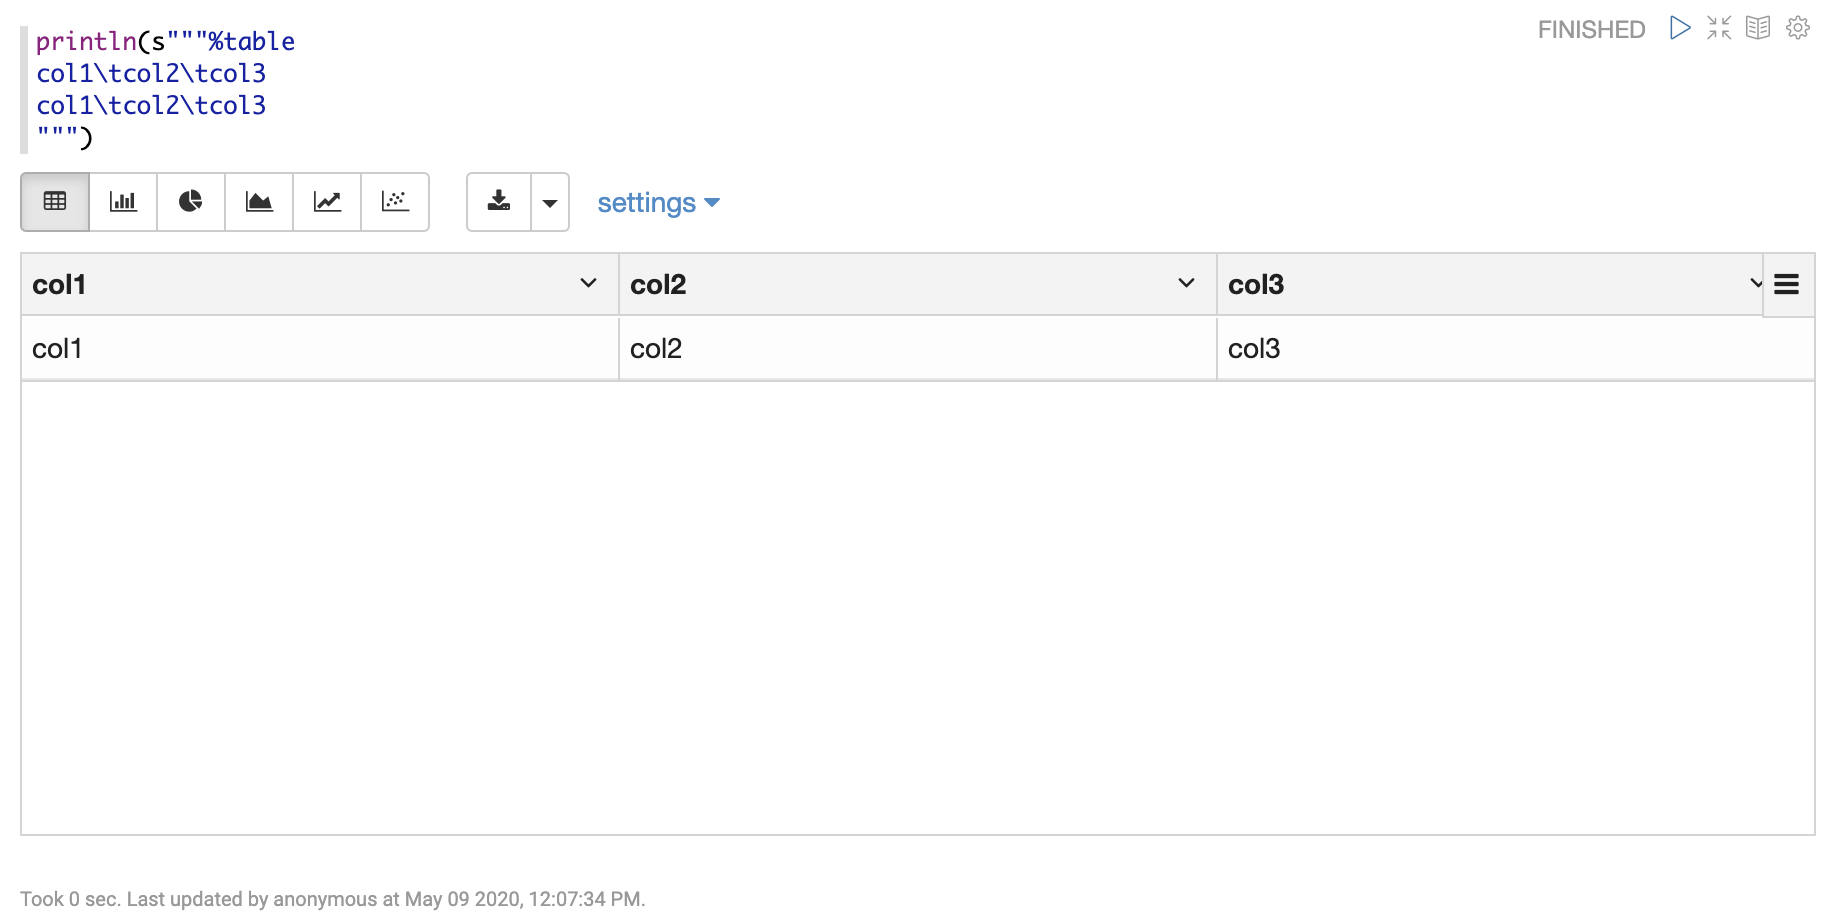

In [25]:
Image('./capture/word2vec_15.png')

-----
### PCA  ( 주성분 분석 )

 - 차원 축소 / 노이즈 제거
 - 산점도 차트
 - chi squared : 영향을 미치는 차원을 골라내는 기법

In [ ]:
sameModel.getVectors

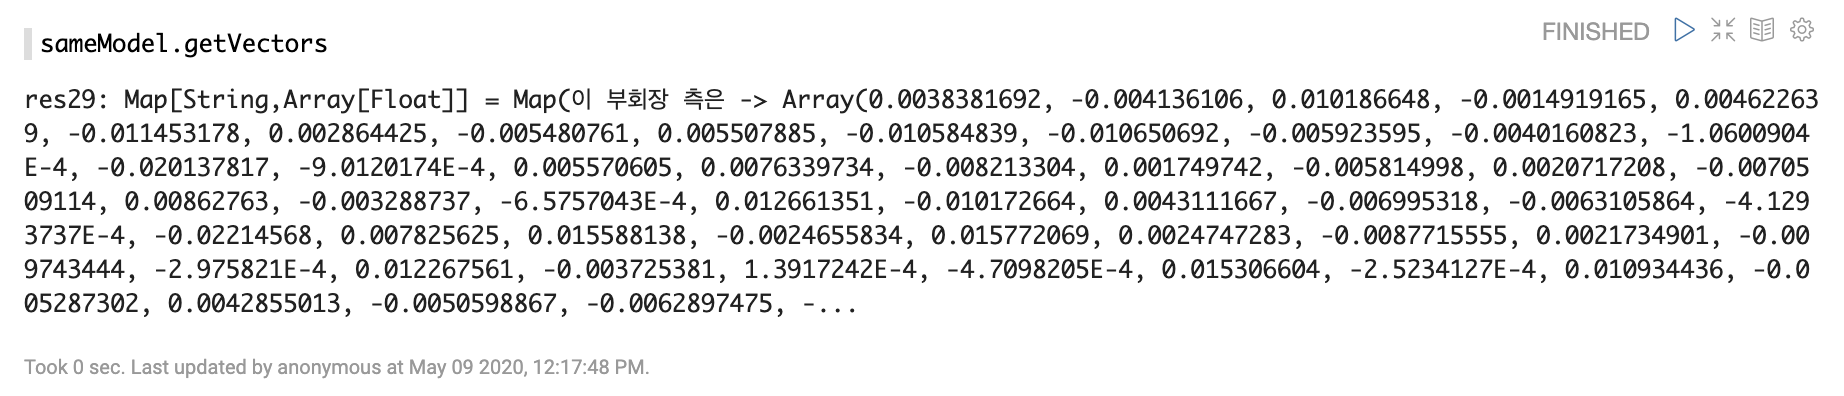

In [26]:
Image('./capture/word2vec_16.png')

In [ ]:
sameModel.getVectors.size

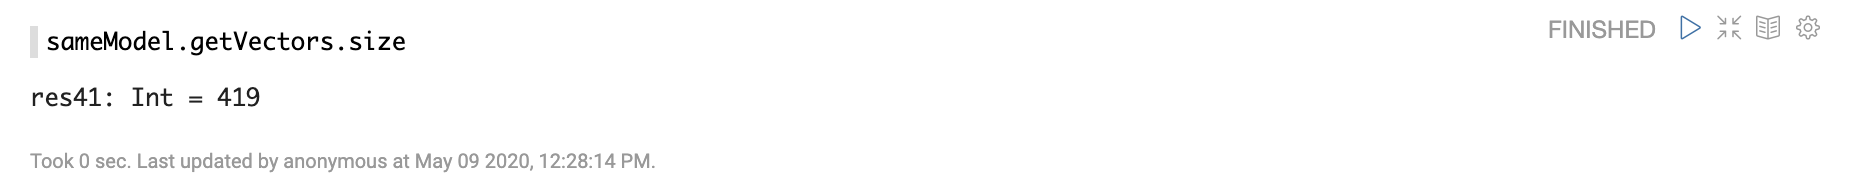

In [33]:
Image('./capture/word2vec_16_02.png')

### Word2VecModel 내 모든 단어에 대한 feature type을 Array[Float]에서 Vector로 변환

In [ ]:
# Dimensionality Reduction by 'Principal Component Analysis (PCA)'

var seq: Seq[(String, Vector)] = Seq()

# def getVectors: Map[String, Array[Float]] => Returns a map of words to their vector representations

sameModel.getVectors.foreach{case (word, vector) =>     
  seq = seq :+ (word, Vectors.dense(vector.map(_.toDouble)))
}    
val seqRDD = sc.parallelize(seq, 2)
println(s""">>>> vector size: ${seq.last._2.size}""")

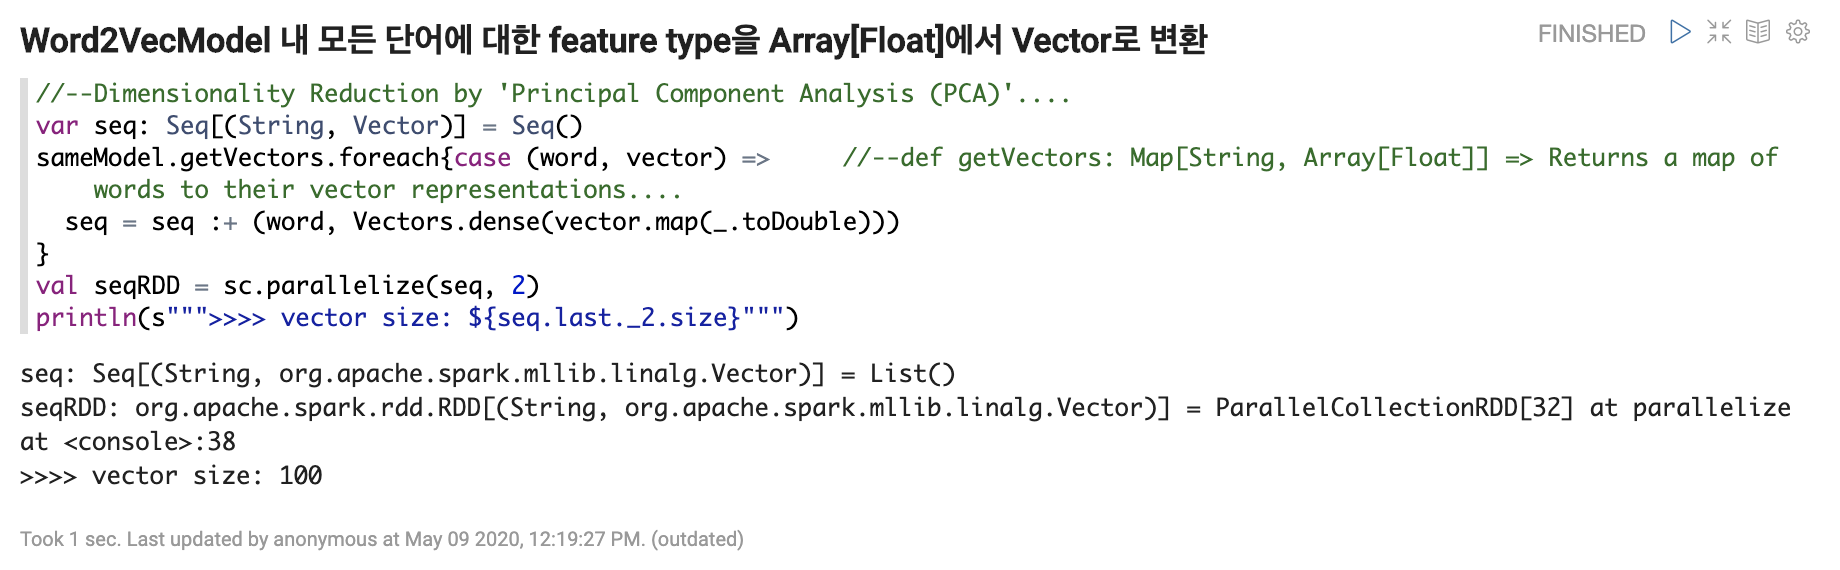

In [28]:
Image('./capture/word2vec_17.png')

### PCA학습 (train)

In [ ]:
import org.apache.spark.mllib.feature.PCA

#Compute the top 2 principal components
# PCA.fit()

val pca = new PCA(2).fit(seqRDD.map(_._2))  
println(s""">>>> pca.k: ${pca.k}""")
println(">>>> Principal component:")
pca.pc.colIter.foreach(println)

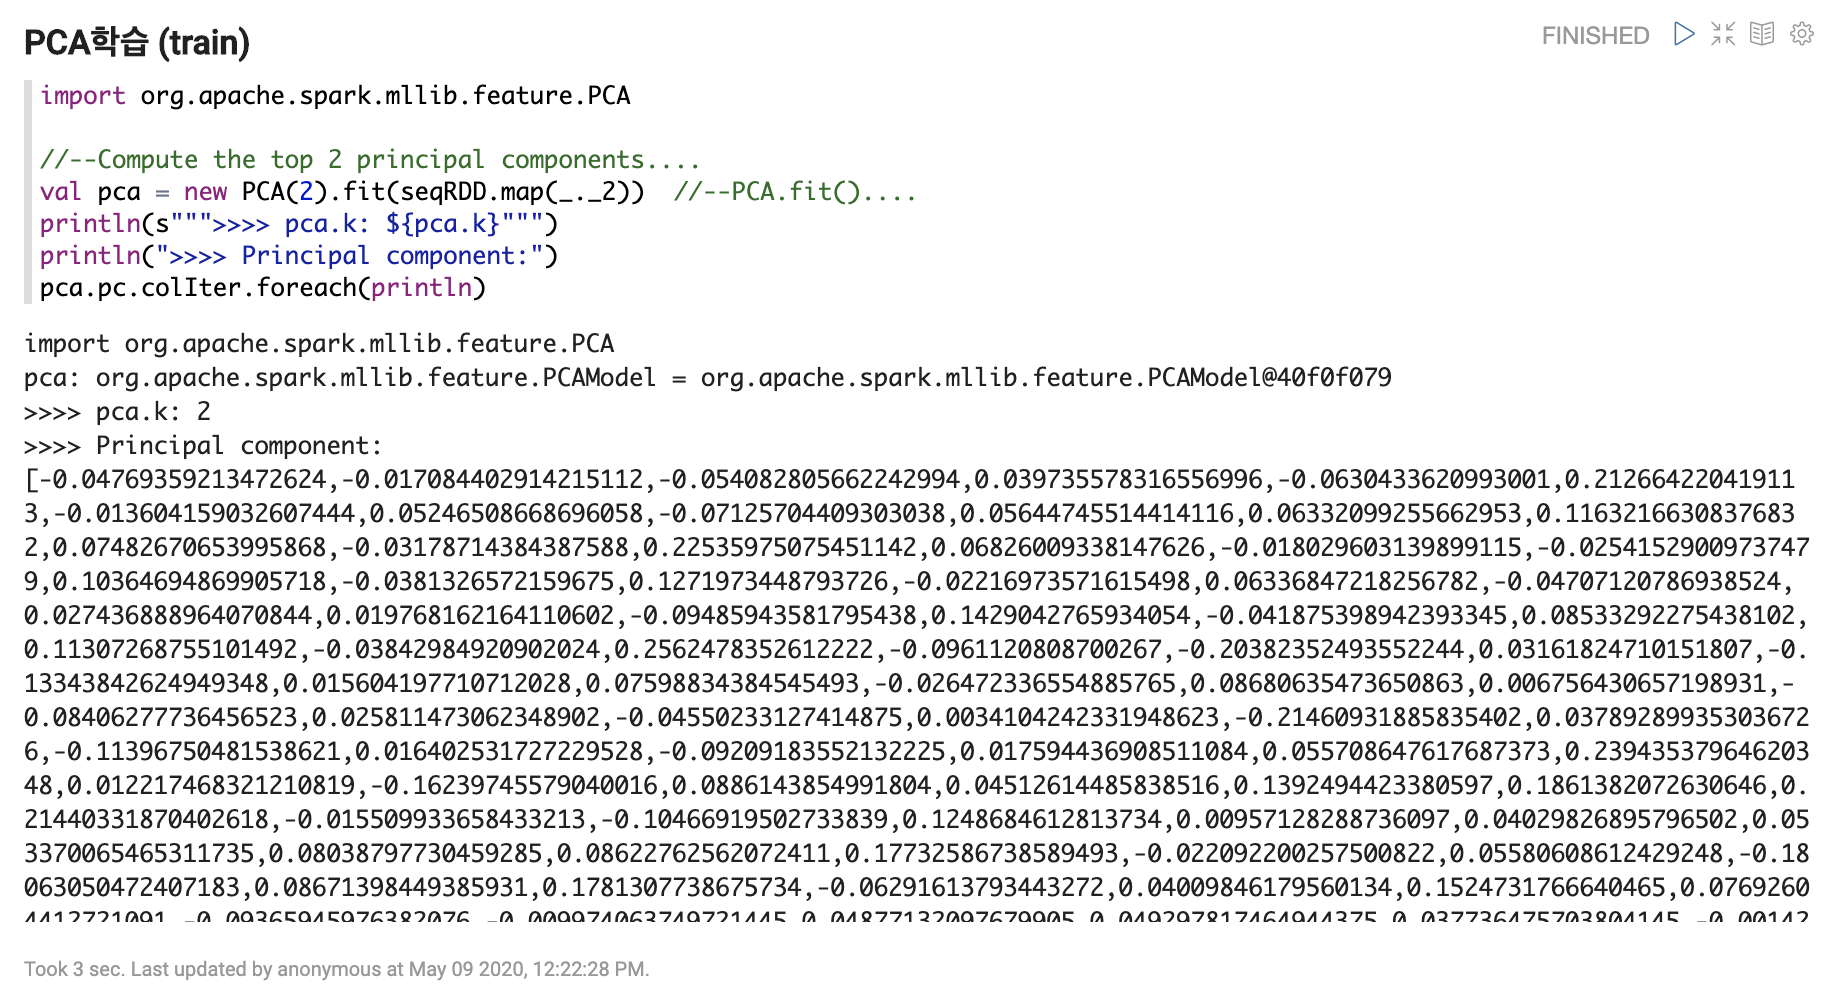

In [29]:
Image('./capture/word2vec_18.png')

In [ ]:
pca.pc

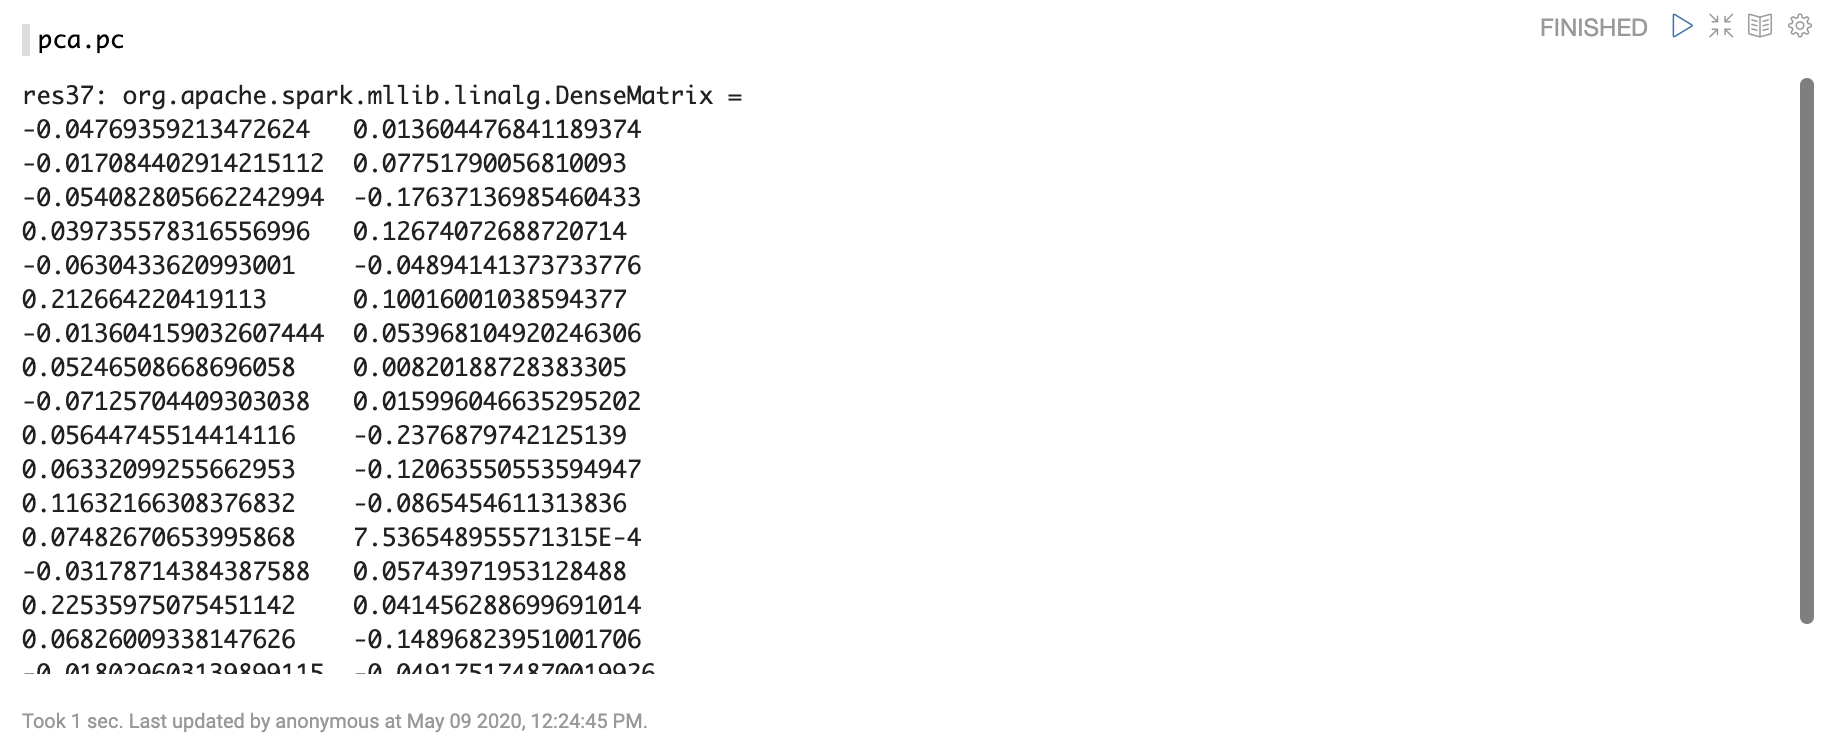

In [30]:
Image('./capture/word2vec_19.png')

In [ ]:
pca.pc.colIter.size

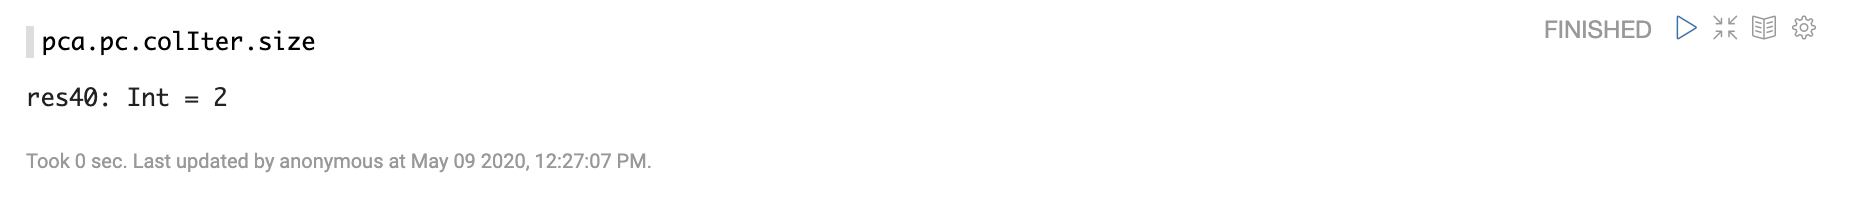

In [32]:
Image('./capture/word2vec_20.png')

In [ ]:
pca.pc.rowIter.size

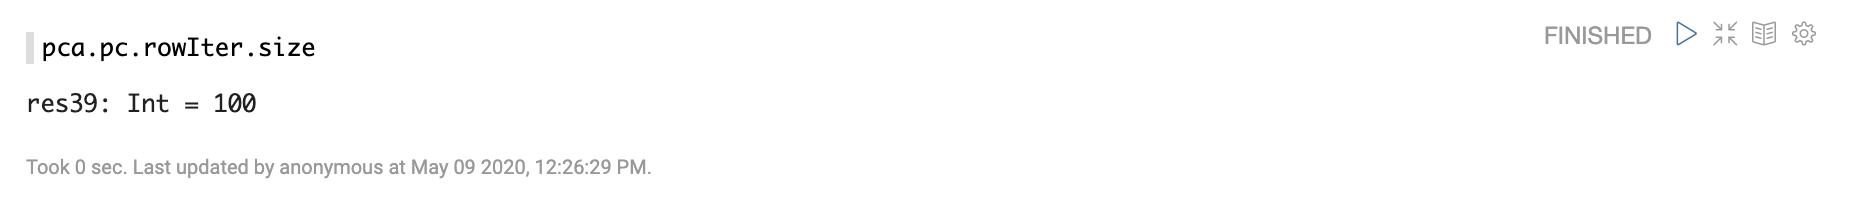

In [31]:
Image('./capture/word2vec_21.png')

-----
### 학습된 PCAModel로 Word2VecModel 내 모든 단어를 차원 축소하여 출력

In [ ]:
var seq2: Seq[(String, Vector)] = Seq()

# def getVectors: Map[String, Array[Float]] => Returns a map of words to their vector representations

sameModel.getVectors.foreach{case (word, vector) =>     

# PCAModel.transform()

 seq2 = seq2 :+ (word, pca.transform(Vectors.dense(vector.map(_.toDouble)))) 
} 
println(">>>> Projected vector of principal component:")
seq2.foreach(println)

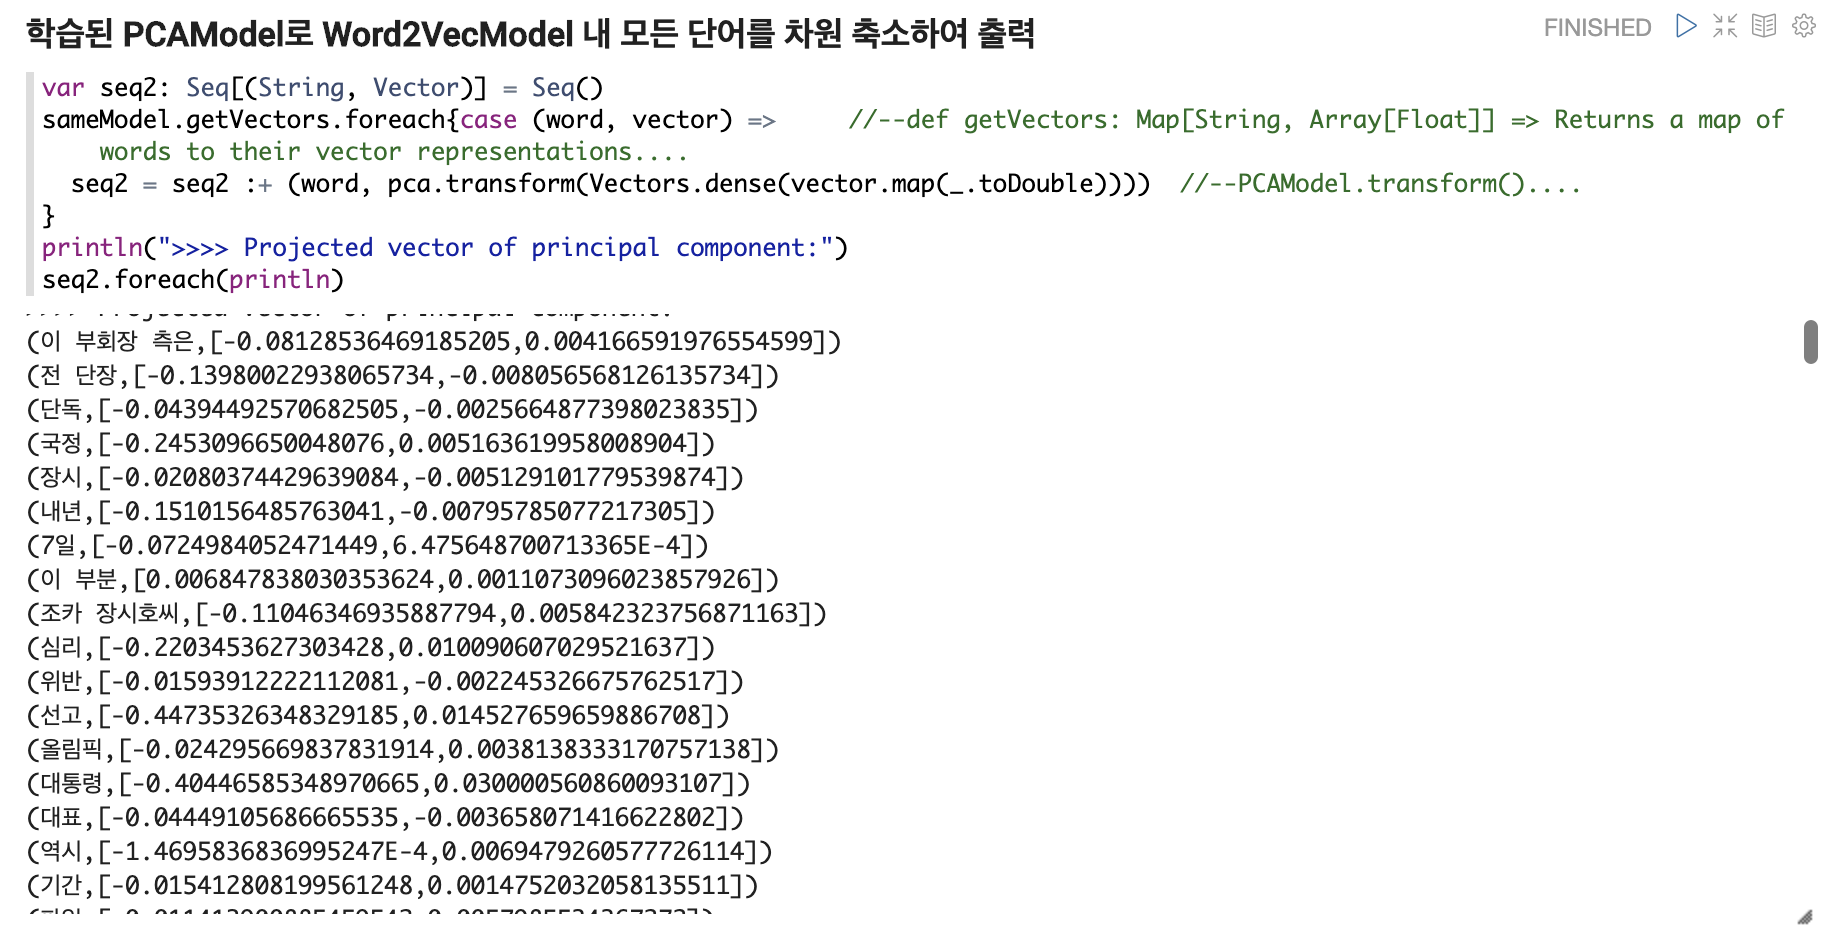

In [34]:
Image('./capture/word2vec_22.png')

----
### Word2Vec Visualization

In [ ]:
var vegasSeq: Seq[Map[String, Any]] = Seq()    
seq2.foreach {case (word, vector) => 
    if(
         word.equals("박근혜")
      || word.equals("최순실")
      || word.equals("이재용")
      || word.equals("대통령")
      || word.equals("박근혜 전 대통령")
      || word.equals("대통령과 최씨")
      || word.equals("삼성")
      || word.equals("K스포츠재단")          
      || word.equals("미르")
    ) {
    vegasSeq = vegasSeq :+ Map("word" -> word, "feature1" -> vector(0), "feature2" -> vector(1))
    }
}

### 차원 축소된 단어 중에서 시각화 할 단어만 필터링

In [ ]:
val seq3 = seq2.filter{case (word, vector) =>
(      word.equals("박근혜")
  || word.equals("최순실")
  || word.equals("이재용")
  || word.equals("대통령")
  || word.equals("박근혜 전 대통령")
  || word.equals("대통령과 최씨")
  || word.equals("삼성")
  || word.equals("K스포츠재단")          
  || word.equals("미르")
)
}

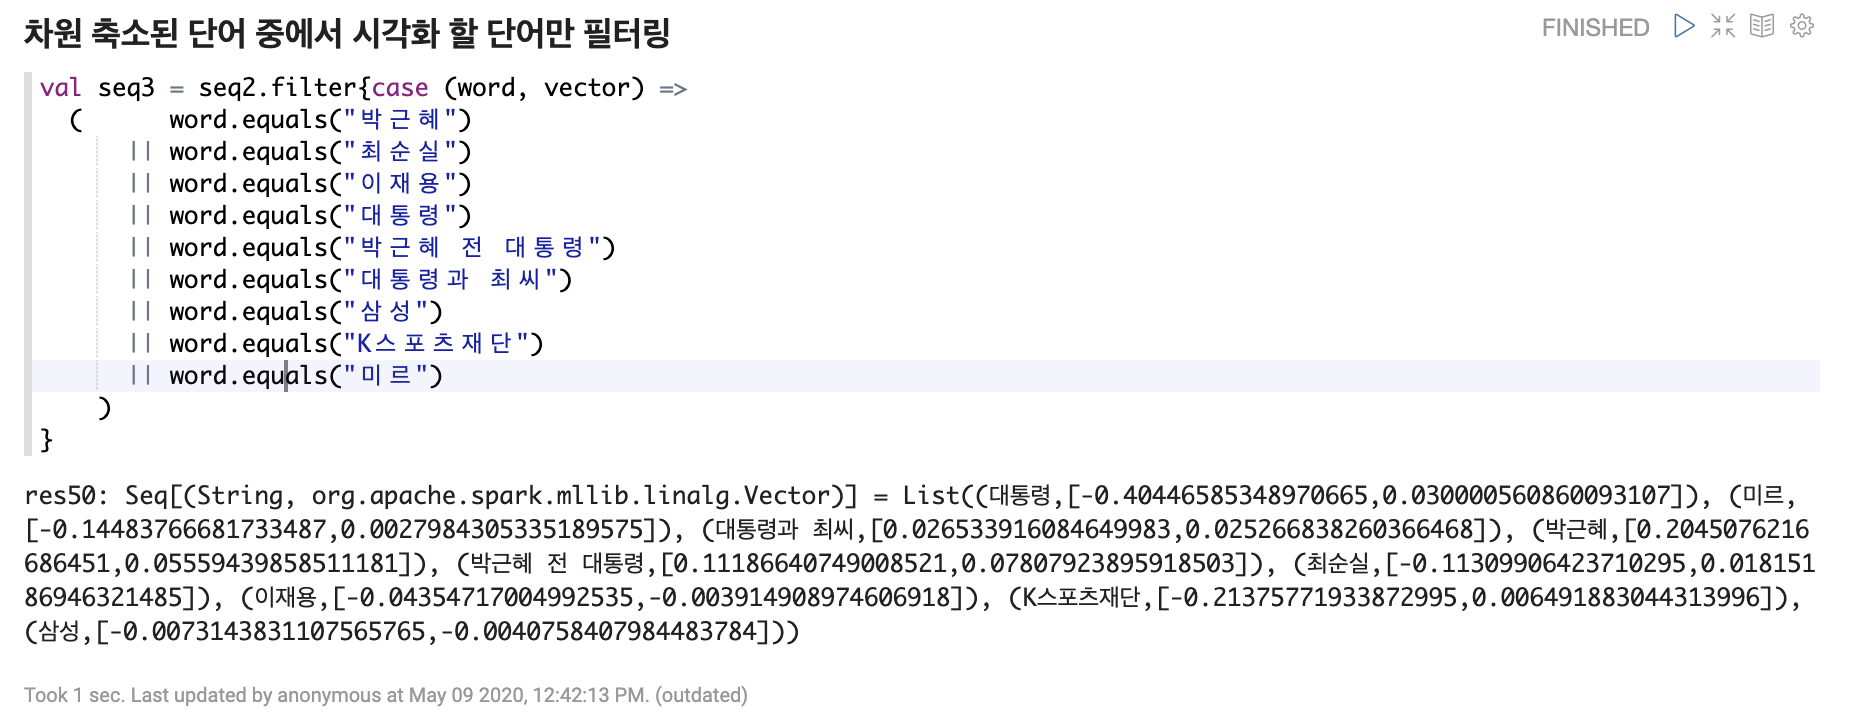

In [35]:
Image('./capture/word2vec_23.png')

In [ ]:
val seq3 = seq2.filter{case (word, vector) =>
  (      word.equals("박근혜")
      || word.equals("최순실")
      || word.equals("이재용")
      || word.equals("대통령")
      || word.equals("박근혜 전 대통령")
      || word.equals("대통령과 최씨")
      || word.equals("삼성")
      || word.equals("K스포츠재단")          
      || word.equals("미르")
    )
} //Seq[(String, Vector)] => Seq[(String, Double, Double)]
.map((_._1))

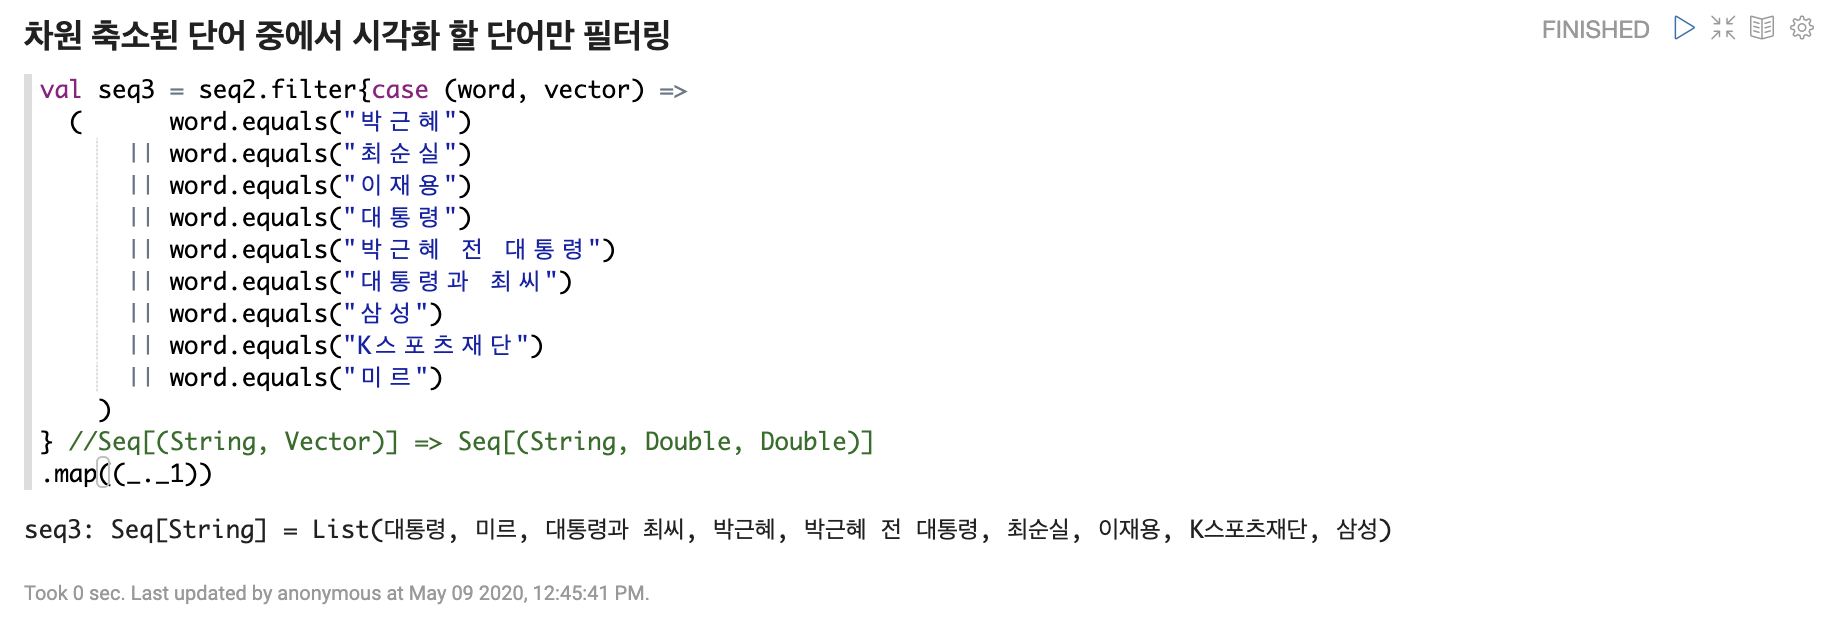

In [36]:
Image('./capture/word2vec_24.png')

In [ ]:
val seq3 = seq2.filter{case (word, vector) =>
  (      word.equals("박근혜")
      || word.equals("최순실")
      || word.equals("이재용")
      || word.equals("대통령")
      || word.equals("박근혜 전 대통령")
      || word.equals("대통령과 최씨")
      || word.equals("삼성")
      || word.equals("K스포츠재단")          
      || word.equals("미르")
    )
} //Seq[(String, Vector)] => Seq[(String, Double, Double)]
.map(x => (x._1, x._2(0), x._2(1)))

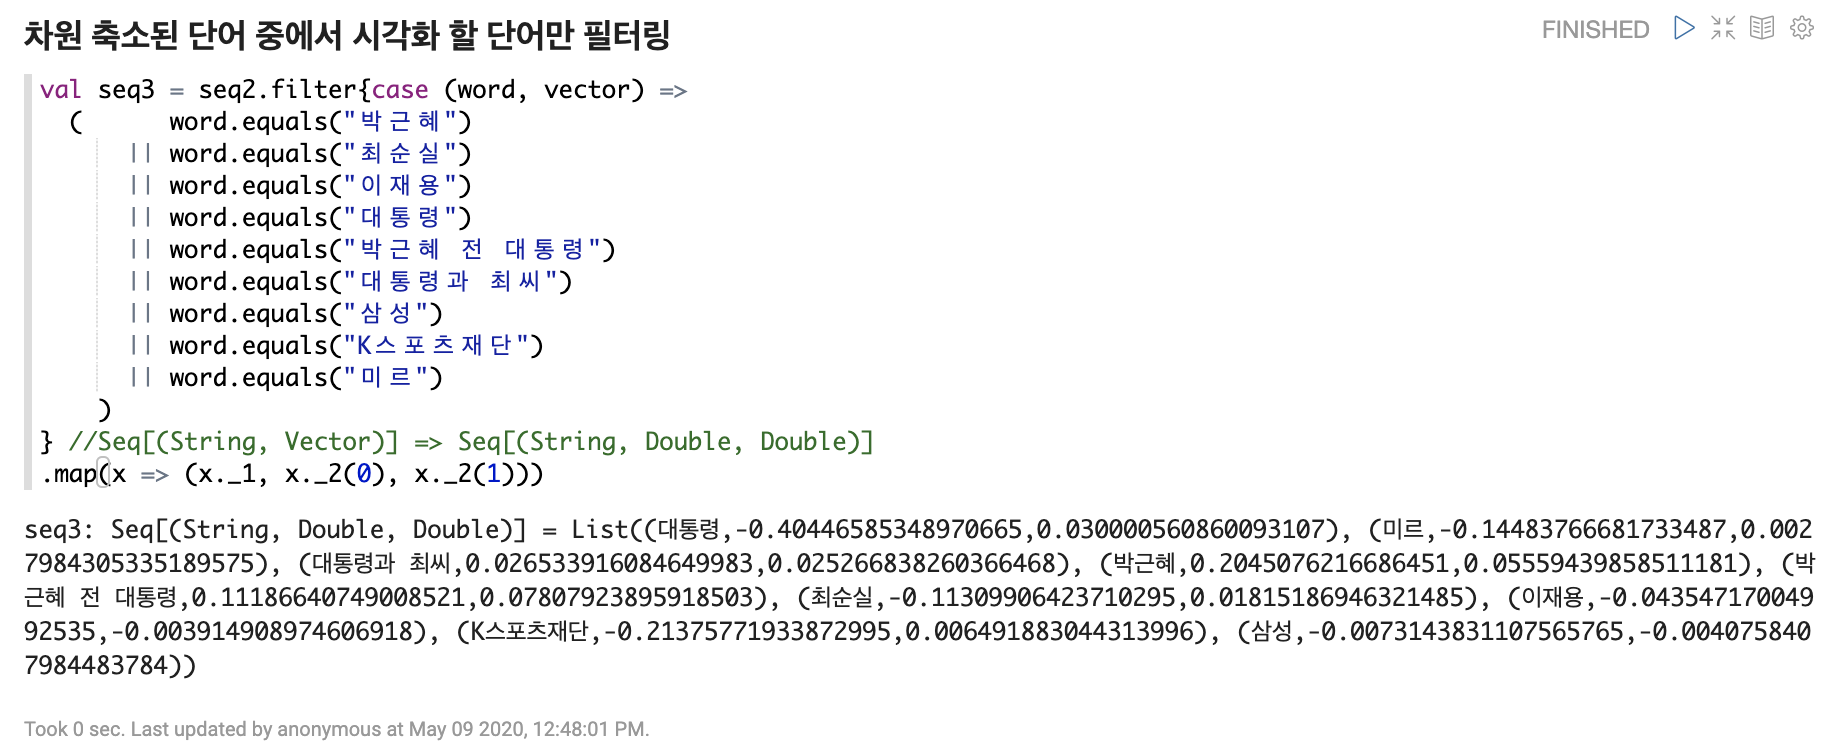

In [37]:
Image('./capture/word2vec_25.png')

-----
### 시각화 산점도 차트

x : feature1
y : feature2
group : word

In [ ]:
println(s"""%table
word\tfeature1\tfeature2
${seq3.map(x => x._1 + "\t" + x._2 + "\t" + x._3).mkString("\n")}
""")

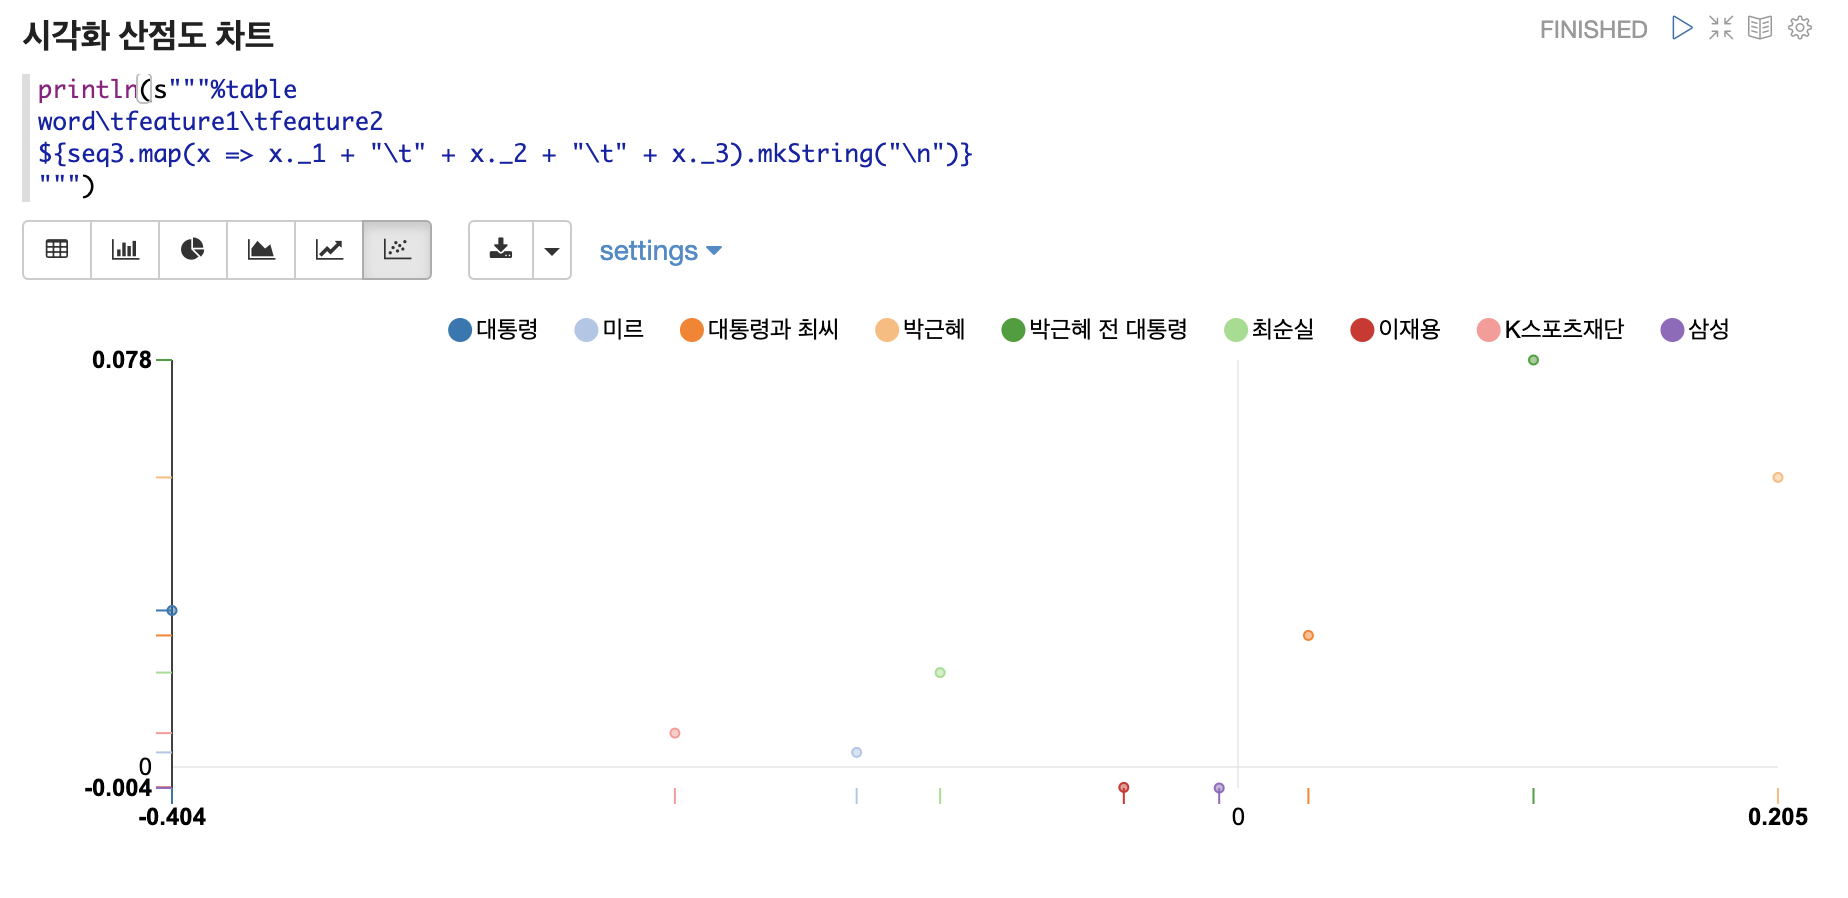

In [38]:
Image('./capture/word2vec_26.png')